In [1]:
import os
import pandas as pd
import scanpy as sc
import anndata as ad
from gprofiler import GProfiler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind


In [2]:
#Set working directory for aggregated wt mice
os.chdir('/media/drive_c/Project_Brain_snRNAseq/Analysis/')

In [3]:

"""
Note: The original ingest for analysis filtered on the the 2000 HVGs, droping all lower variable genes. To preform DEG/GO/GSEA, this script\
     processes multiple 10x Genomics datasets, filtering and annotating cells based on a taxonomy mapping file It performs the following steps:

1. Loads multiple 10x datasets.

2. Filters each to retain only mapped cells (from a taxonomy file).

3. Annotates each cell with taxonomy (class, subclass, supertype, cluster) and sample-level metadata (group, sample).

4. Normalizes and log-transforms expression.

5. Merges everything into one AnnData object.

"""


# === Step 1: Setup ===
root_dir = "/media/drive_c/Project_Brain_snRNAseq/per_sample_outs" # location of the h5 files
mapping_csv = "/media/drive_c/Project_Brain_snRNAseq/Analysis/mapping_output.csv"  # mapping output from Mapmycells to identify cell types for subsetting
mapping_df = pd.read_csv(mapping_csv, skiprows=4)
mapping_df.set_index("cell_id", inplace=True)

# === Step 2: Load and Process Each Sample ===
adatas = []

for sample_folder in os.listdir(root_dir):
    sample_path = os.path.join(root_dir, sample_folder, 'count', 'sample_filtered_feature_bc_matrix.h5')
    if not os.path.isfile(sample_path):
        continue

    # Load the sample
    adata = sc.read_10x_h5(sample_path)
    adata.var_names_make_unique()
    
    # Keep a copy of raw counts in .layers and .raw
    adata.layers["counts"] = adata.X.copy()

    # Format barcodes to match mapping (adjust if mapping uses sample-barcode format)
    adata.obs_names = [f"{bc}" for bc in adata.obs_names]

    # Filter to cells that were mapped
    mapped_cells = mapping_df.index.intersection(adata.obs_names)
    adata = adata[mapped_cells].copy()

    # Add taxonomy annotations from mapping
    adata.obs['class'] = mapping_df.loc[mapped_cells, 'class_name'].values
    adata.obs['subclass'] = mapping_df.loc[mapped_cells, 'subclass_name'].values
    adata.obs['supertype'] = mapping_df.loc[mapped_cells, 'supertype_name'].values
    adata.obs['cluster'] = mapping_df.loc[mapped_cells, 'cluster_name'].values

    # Add group label from folder name
    if 'Mock' in sample_folder:
        adata.obs['group'] = 'Mock'
    elif 'OG' in sample_folder:
        adata.obs['group'] = 'OG'
    else:
        adata.obs['group'] = 'Unknown'

    # Add sample label
    adata.obs['sample'] = sample_folder

    # Normalize and log-transform (store result in a new layer)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.layers["log_norm"] = adata.X.copy()

    # Store raw object (contains original counts and full gene list)
    adata.raw = adata.copy()

    adatas.append(adata)

# === Step 3: Concatenate All Samples ===
adata_combined = ad.concat(adatas, label='sample', index_unique=None)

# Save final AnnData object
adata_combined.write("combined_filtered_prunning.h5ad")

/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_u

In [4]:
adata_combined

AnnData object with n_obs × n_vars = 51585 × 19059
    obs: 'class', 'subclass', 'supertype', 'cluster', 'group', 'sample'
    layers: 'counts', 'log_norm'

In [6]:
adata_combined.obs.nunique()


class          33
subclass      299
supertype    1059
cluster      3893
group           2
sample          6
dtype: int64

# DEG Analysis by Annotated Cell-type

In [ ]:
def run_dge_per_annotation_level(
    adata,
    annotation_level='cluster',      # 'class', 'subclass', 'supertype', etc.
    group_key='group',               # condition to compare: test vs control
    test_label='OG',
    control_label='Mock',
    logfc_thresh=1,
    pval_thresh=0.05,
    output_dir=None                  # directory to save Excel file; if None, no saving
):
    """
    Perform within-cell-type differential gene expression (DGE) across a specified annotation level.

    Step-by-step:
    1. For each unique value of `annotation_level` (e.g., each 'subclass'):
        - Subset the data to that group
        - Run Wilcoxon rank-sum DGE between test and control labels
        - Extract results: logFC, raw p-values
        - Recalculate FDR-adjusted p-values (Benjamini–Hochberg)
        - Tag each row with the cell type name
    2. Aggregate all DGE results into one combined table.
    3. If `output_dir` is provided:
        - Save results as `DGE_level_<annotation_level>.xlsx`
        - Each sheet contains results for one cell type (max 31 characters for Excel)
        - A final sheet named 'Code_Used' logs the function configuration and method details

    Parameters:
        adata (AnnData): Annotated data matrix.
        annotation_level (str): Column in `adata.obs` defining cell types or taxonomy.
        group_key (str): Column indicating test vs control groups.
        test_label (str): Label for the test group.
        control_label (str): Label for the reference/control group.
        logfc_thresh (float): Log2 fold-change threshold for significance (not used for filtering here).
        pval_thresh (float): p-value threshold for filtering (not used for filtering here).
        output_dir (str or None): Folder where Excel file will be saved (if provided).

    Returns:
        dict with:
            - 'dge_results': dict of DataFrames, one per cell type
            - 'dge_summary': concatenated DataFrame of all results
    """
    

    dge_results = {}
    dge_summary = []
    layer_used = 'log_norm' if 'log_norm' in adata.layers else None

    for cell_type in adata.obs[annotation_level].unique():
        print(f"Processing: {cell_type}")
        adata_sub = adata[adata.obs[annotation_level] == cell_type].copy()

        group_counts = adata_sub.obs[group_key].value_counts()
        if (
            test_label not in group_counts or
            control_label not in group_counts or
            group_counts[test_label] < 2 or
            group_counts[control_label] < 2
        ):
            print(f"Skipping {cell_type} — insufficient cells")
            continue

        # Run DGE using all genes
        sc.tl.rank_genes_groups(
            adata_sub,
            groupby=group_key,
            groups=[test_label],
            reference=control_label,
            method='wilcoxon',
            use_raw=False,
            layer=layer_used,
            n_genes=adata_sub.shape[1]
        )

        # Extract and format
        dge_df = sc.get.rank_genes_groups_df(adata_sub, group=test_label)
        dge_df.rename(columns={
            'names': 'gene',
            'pvals': 'p_val',
            'pvals_adj': 'scanpy_padj',
            'logfoldchanges': 'logFC'
        }, inplace=True)
        dge_df['p_val'] = dge_df['p_val'].fillna(1.0)

        # Recalculate FDR across full set
        pvals = dge_df['p_val'].values
        p_adj = multipletests(pvals, method='fdr_bh')[1]
        dge_df['p_adj'] = p_adj
        dge_df['cell_type'] = cell_type

        dge_results[cell_type] = dge_df
        dge_summary.append(dge_df)

    # Combine summary
    dge_all = pd.concat(dge_summary, ignore_index=True) if dge_summary else pd.DataFrame()

    # Save to Excel
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        file_path = os.path.join(output_dir, f"DGE_level_{annotation_level}.xlsx")
        with pd.ExcelWriter(file_path) as writer:
            for ct, df in dge_results.items():
                sheet_name = str(ct).replace('/', '_')[:31]  # Excel sheet name max length = 31
                df.to_excel(writer, sheet_name=sheet_name, index=False)

            # Include code chunk used
            code_string = f"""\


 

# DGE run per cell type in: {annotation_level}
# Test vs Control: {test_label} vs {control_label}

# Minimum logFC: {logfc_thresh}
# P-value threshold: {pval_thresh}

# Scanpy used Wilcoxon test on layer: {layer_used if layer_used else 'X'}

# FDR correction: Benjamini–Hochberg (FDR) via statsmodels

# This output was generated with: run_dge_per_annotation_level(...)
"""
            code_df = pd.DataFrame({'Code': code_string.splitlines()})
            code_df.to_excel(writer, sheet_name="Code_Used", index=False)

    return {
        'dge_results': dge_results,
        'dge_summary': dge_all
    }


## Running the DGE function on each level


class          33\
subclass      299\
supertype    1059\
cluster      3893\
group           2\
sample          6\


In [8]:
annotation_levels = ['class', 'subclass', 'supertype', 'cluster']
output_root = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/DGE"

for level in annotation_levels:
    print(f"\nRunning DGE at annotation level: {level}")
    run_dge_per_annotation_level(
        adata_combined,
        annotation_level=level,
        group_key='group',
        test_label='OG',
        control_label='Mock',
        logfc_thresh=1,
        pval_thresh=0.05,
        output_dir=output_root
    )



Running DGE at annotation level: class
Processing: 31 OPC-Oligo
Processing: 11 CNU-HYa GABA
Processing: 07 CTX-MGE GABA
Processing: 20 MB GABA
Processing: 14 HY Glut
Processing: 01 IT-ET Glut
Processing: 12 HY GABA
Processing: 02 NP-CT-L6b Glut
Processing: 19 MB Glut
Processing: 08 CNU-MGE GABA
Processing: 03 OB-CR Glut
Processing: 10 LSX GABA
Processing: 33 Vascular
Processing: 18 TH Glut
Processing: 13 CNU-HYa Glut
Processing: 27 MY GABA
Processing: 05 OB-IMN GABA
Processing: 06 CTX-CGE GABA
Processing: 09 CNU-LGE GABA
Processing: 26 P GABA
Processing: 34 Immune
Processing: 04 DG-IMN Glut
Processing: 23 P Glut
Processing: 22 MB-HB Sero
Processing: 29 CB Glut
Processing: 24 MY Glut
Processing: 21 MB Dopa
Processing: 28 CB GABA
Processing: 17 MH-LH Glut
Processing: 30 Astro-Epen
Processing: 16 HY MM Glut
Processing: 32 OEC
Processing: 25 Pineal Glut
Skipping 25 Pineal Glut — insufficient cells

Running DGE at annotation level: subclass
Processing: 327 Oligo NN
Processing: 073 MEA-BST 

# Cell Count by sample



In [10]:
import os
import pandas as pd

# Set output directory
output_dir = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts"
os.makedirs(output_dir, exist_ok=True)

# Choose annotation levels to analyze
annotation_levels = ['class', 'subclass', 'supertype', 'cluster']  # adjust as needed

# Build sample → group mapping
sample_group_map = (
    adata_combined.obs[['sample', 'group']]
    .drop_duplicates()
    .set_index('sample')['group']
)

# Loop through each annotation level
for level in annotation_levels:
    print(f"Processing annotation level: {level}")

    # Count cells per annotation level and sample
    count_df = pd.crosstab(adata_combined.obs[level], adata_combined.obs['sample'])

    # Save wide format (optional but sometimes useful)
    wide_outfile = os.path.join(output_dir, f"cell_counts_{level}_wide.csv")
    count_df.to_csv(wide_outfile)

    # Convert wide to long format
    df_long = count_df.reset_index().melt(
        id_vars=level,
        var_name='sample',
        value_name='count'
    )

    # Add group column
    df_long['group'] = df_long['sample'].map(sample_group_map)

    # Rename column for consistency
    df_long = df_long.rename(columns={level: 'celltype'})

    # Reorder columns
    df_long = df_long[['celltype', 'group', 'sample', 'count']]

    # Save long format
    long_outfile = os.path.join(output_dir, f"cell_counts_{level}_long.csv")
    df_long.to_csv(long_outfile, index=False)

    print(f"Saved long-form cell count table to: {long_outfile}")


Processing annotation level: class
Saved long-form cell count table to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/cell_counts_class_long.csv
Processing annotation level: subclass
Saved long-form cell count table to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/cell_counts_subclass_long.csv
Processing annotation level: supertype
Saved long-form cell count table to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/cell_counts_supertype_long.csv
Processing annotation level: cluster
Saved long-form cell count table to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/cell_counts_cluster_long.csv


# Calculate SigDif in cell types

In [ ]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import pandas as pd

def run_groupwise_celltype_ttests(df_long, level_name):
    """
    Perform Welch's t-tests per celltype and apply FDR correction.
    """
    raw_results = []

    for celltype in df_long['celltype'].unique():
        sub_df = df_long[df_long['celltype'] == celltype]
        groups = sub_df['group'].unique()

        if len(groups) != 2:
            continue  # skip if not exactly 2 groups

        g1, g2 = groups
        g1_vals = sub_df[sub_df['group'] == g1]['count']
        g2_vals = sub_df[sub_df['group'] == g2]['count']

        if len(g1_vals) < 2 or len(g2_vals) < 2:
            continue  # skip if too few replicates

        stat, pval = ttest_ind(g1_vals, g2_vals, equal_var=False)

        raw_results.append({
            'annotation_level': level_name,
            'celltype': celltype,
            'group1': g1,
            'group2': g2,
            f'{g1}_mean': g1_vals.mean(),
            f'{g2}_mean': g2_vals.mean(),
            'pval': pval
        })

    # Convert to DataFrame
    df = pd.DataFrame(raw_results)

    if df.empty:
        return df

    # FDR correction
    corrected = multipletests(df['pval'], method='fdr_bh')
    df['adj_pval'] = corrected[1]

    # Significance based on adj_pval
    def get_star(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'

    df['significance'] = df['adj_pval'].apply(get_star)

    return df


# Plot cell counts by level

/mnt/scratch/ipykernel_411807/2920745706.py:33: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


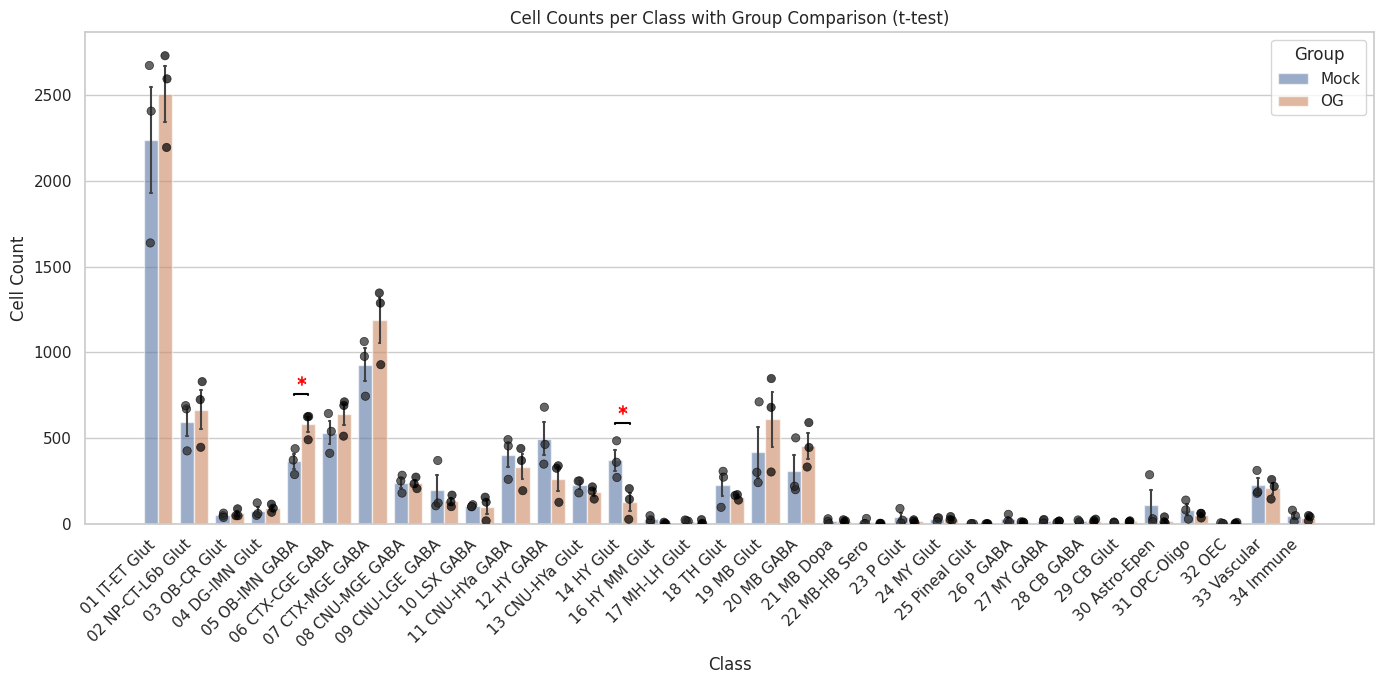

In [35]:
# Note: this code uses the wide format cell counts CSV for class level that was directly edited to include group_sample# for columns, replicating previous code/cvs... (It is a vertical plot!!!!!!!!)

# Load the cell counts CSV for class level
count_df = pd.read_csv("/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/cell_counts_class.csv", index_col=0)

# Remove Total column if exists
if 'Total' in count_df.columns:
    count_df = count_df.drop(columns='Total')

# Convert wide to long format
df_long = count_df.reset_index().melt(id_vars='class', var_name='Group_Sample', value_name='Cell_Count')

# Split Group_Sample into 'Group' and 'Sample'
df_long[['Group', 'Sample']] = df_long['Group_Sample'].str.split('_', expand=True)

# Set plot size and style
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Barplot with SEM error bars
bar_plot = sns.barplot(
    data=df_long,
    x='class',
    y='Cell_Count',
    hue='Group',
    errorbar='se',                   # <- SEM
    capsize=0.1,
    err_kws={'linewidth': 1.5},      # <- replaces deprecated errwidth
    alpha=0.6
)

# Overlay stripplot (dots)
sns.stripplot(
    data=df_long,
    x='class',
    y='Cell_Count',
    hue='Group',
    dodge=True,
    jitter=True,
    palette='dark:black',           # <- replaces deprecated color='black'
    alpha=0.7,
    size=6,
    edgecolor='gray',
    linewidth=0.5
)

# Remove duplicate legend entries
handles, labels = bar_plot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Group')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Cell Count")
plt.xlabel("Class")
plt.title("Cell Counts per Class with Group Comparison (t-test)")

# Add significance stars per class using Welch's t-test
classes = df_long['class'].unique()
y_max = df_long['Cell_Count'].max()

for i, c in enumerate(classes):
    mock_vals = df_long[(df_long['class'] == c) & (df_long['Group'] == 'Mock')]['Cell_Count']
    og_vals = df_long[(df_long['class'] == c) & (df_long['Group'] == 'OG')]['Cell_Count']

    # Perform Welch's t-test (independent t-test)
    stat, p = ttest_ind(mock_vals, og_vals, equal_var=False)

    # Position for annotation
    y = max(mock_vals.mean(), og_vals.mean()) * 1.1

    # Add star or ns
    if p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = None

    if sig:
        x1 = i - 0.2  # Mock position
        x2 = i + 0.2  # OG position
        y_max_i = max(mock_vals.max(), og_vals.max())
        y = y_max_i * 1.2

        # Draw line (bracket)
        plt.plot([x1, x1, x2, x2], [y, y + 5, y + 5, y], lw=1.5, c='black')
        plt.text((x1 + x2) / 2, y + 5.5, sig, ha='center', va='bottom', fontsize=14, color='red')


    plt.text(i, y, sig, ha='center', va='bottom', fontsize=14, color='red')

plt.tight_layout()
plt.savefig("/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Celltype_count_Class_plot.svg", format='svg')
plt.show()

/mnt/scratch/ipykernel_411807/1024115803.py:31: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


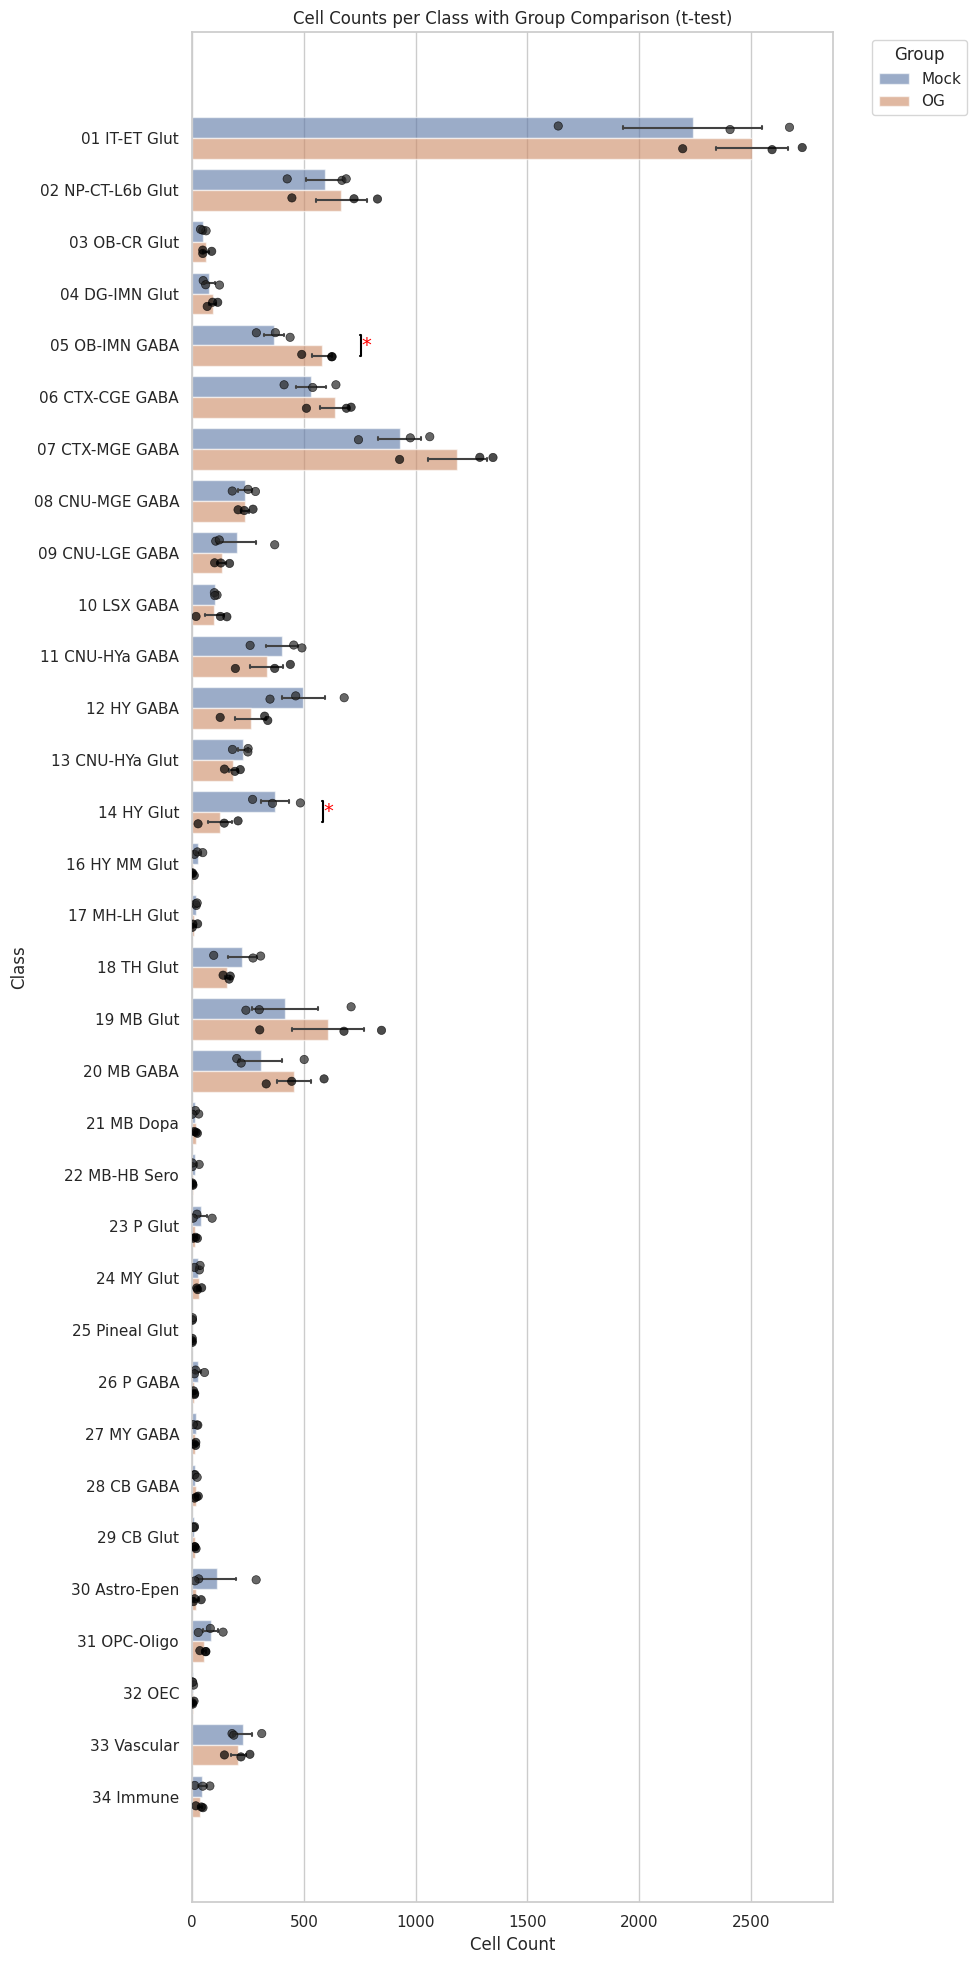

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load CSV
count_df = pd.read_csv("/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/cell_counts_class.csv", index_col=0)
count_df = count_df.drop(columns=['Total'], errors='ignore')

# Convert wide → long
df_long = count_df.reset_index().melt(id_vars='class', var_name='Group_Sample', value_name='Cell_Count')
df_long[['Group', 'Sample']] = df_long['Group_Sample'].str.split('_', expand=True)

# Plot setup
plt.figure(figsize=(10, 0.6 * len(df_long['class'].unique())))
sns.set(style="whitegrid")

# Horizontal bar plot
bar_plot = sns.barplot(
    data=df_long,
    y='class',
    x='Cell_Count',
    hue='Group',
    errorbar='se',
    capsize=0.1,
    err_kws={'linewidth': 1.5},
    alpha=0.6
)

# Overlay stripplot
sns.stripplot(
    data=df_long,
    y='class',
    x='Cell_Count',
    hue='Group',
    dodge=True,
    jitter=True,
    palette='dark:black',
    alpha=0.7,
    size=6,
    edgecolor='gray',
    linewidth=0.5
)

# Remove duplicate legends
handles, labels = bar_plot.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel("Class")
plt.xlabel("Cell Count")
plt.title("Cell Counts per Class with Group Comparison (t-test)")

# Add significance stars
classes = df_long['class'].unique()
for i, c in enumerate(classes):
    control_vals = df_long[(df_long['class'] == c) & (df_long['Group'] == 'Mock')]['Cell_Count']
    test_vals = df_long[(df_long['class'] == c) & (df_long['Group'] == 'OG')]['Cell_Count']

    stat, p = ttest_ind(control_vals, test_vals, equal_var=False)

    if p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = None

    if sig:
        x_max_i = max(control_vals.max(), test_vals.max())
        x = x_max_i * 1.2
        # Horizontal bracket
        plt.plot([x, x + 5, x + 5, x], [i - 0.2, i - 0.2, i + 0.2, i + 0.2], lw=1.5, c='black')
        plt.text(x + 5.5, i, sig, ha='left', va='center', fontsize=14, color='red')

plt.tight_layout()
plt.savefig("/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Celltype_count_Class_plot_horizontal.svg", format='svg')
plt.show()


## Hierarchy DF

In [48]:
# Build the full annotation hierarchy table
hierarchy_df = (
    adata_combined.obs[['class', 'subclass', 'supertype', 'cluster']]
    .drop_duplicates()
    .sort_values(by=['class', 'subclass', 'supertype', 'cluster'])
    .reset_index(drop=True)
)

# Save or view
hierarchy_df.to_csv("/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv", index=False)
display(hierarchy_df.head(10))


,class,subclass,supertype,cluster
0,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,0001 CLA-EPd-CTX Car3 Glut_1,0001 CLA-EPd-CTX Car3 Glut_1
1,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1
2,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,0001 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1
3,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,0001 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1
4,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,0002 CLA-EPd-CTX Car3 Glut_2,0005 CLA-EPd-CTX Car3 Glut_2
5,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,0006 IT EP-CLA Glut_1
6,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1
7,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1
8,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1
9,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,0010 IT EP-CLA Glut_1


## Function to look up cell-types

In [49]:

"""
Given a hierarchy table, return all sub-level values under a specific reference celltype.
    
  Parameters:
    - hierarchy_df: DataFrame with 'class', 'subclass', 'supertype', 'cluster' columns
    - reference_level: the higher level of annotation (e.g., 'class')
    - reference_celltype: the name of the celltype in that level
    - sub_level: the level below to extract (e.g., 'subclass')

  Returns:
    - List of unique sub-level celltypes under the reference celltype

"""



def get_subtypes_from_reference(hierarchy_df, reference_level, reference_celltype, sub_level):
    
    # Check column order (ensures sub_level is below reference_level)
    levels = ['class', 'subclass', 'supertype', 'cluster']
    if reference_level not in levels or sub_level not in levels:
        raise ValueError("reference_level and sub_level must be one of: " + ", ".join(levels))
    
    ref_idx = levels.index(reference_level)
    sub_idx = levels.index(sub_level)
    if sub_idx <= ref_idx:
        raise ValueError(f"sub_level ('{sub_level}') must be below reference_level ('{reference_level}')")

    # Filter by reference
    subset = hierarchy_df[hierarchy_df[reference_level] == reference_celltype]

    # Extract sub-level values
    subtypes = subset[sub_level].dropna().unique().tolist()

    return subtypes


In [50]:
subtypes = get_subtypes_from_reference(
    hierarchy_df,
    reference_level='class',
    reference_celltype='05 OB-IMN GABA',
    sub_level='subclass'
)

print(subtypes)

['039 OB Meis2 Thsd7b Gaba', '040 OB Trdn Gaba', '041 OB-in Frmd7 Gaba', '042 OB-out Frmd7 Gaba', '043 OB-mi Frmd7 Gaba', '044 OB Dopa-Gaba', '045 OB-STR-CTX Inh IMN']


### Function to plot select subtypes

Plot grouped subtype cell counts with sample points and significance annotations.

Bars are lighter, individual samples are shown, and significant comparisons
are indicated with a connecting line, star, and optional p-value.

##### Parameters
----------
        parent_level : str               Column in hierarchy CSV representing the parent cell type level (e.g., 'class').
        parent_celltype : str            Name of the parent cell type to select (e.g., '05 OB-IMN GABA').
        target_level : str               Column in hierarchy CSV representing the target subtypes under the parent level (e.g., 'subclass').
        hierarchy_csv : str              Path to the CSV file mapping parent cell types to subtypes.
        counts_base_dir : str            Directory containing long-format counts CSVs: cell_counts_<target_level>_long.csv
        control_group : str, 
        test_group : str, 
        correction_method : str or None, default='fdr_bh'
                                        'fdr_bh' → Benjamini-Hochberg FDR correction (common)
                                        'bonferroni' → Bonferroni correction (stringent)
                                        None → no correction
        alpha : float, default=0.05     Significance threshold for p-values
        pval_type : str, default='p'
                                        'p' → raw t-test p-values
                                        'adj_pval' → corrected p-values
        orientation : str, default='v'
                                        'v' → vertical bars (x=subtypes, y=counts)
                                        'h' → horizontal bars (y=subtypes, x=counts)
        show_pval : bool, default=True   Whether to display numeric p-values above bars
        save_dir : str or None,         default=None OR Directory to save plot; if None, plot is shown interactively

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np

def plot_grouped_subtype_counts(
    parent_level,
    parent_celltype,
    target_level,
    hierarchy_csv,
    counts_base_dir,
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',  # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,
    pval_type='p',                # 'p' or 'adj_pval'
    orientation='v',              # 'v' or 'h'
    show_pval=True,               # whether to display numeric p-values
    save_dir=None
):
    
    
    # Load hierarchy mapping
    hierarchy = pd.read_csv(hierarchy_csv)
    target_subtypes = hierarchy.loc[hierarchy[parent_level] == parent_celltype, target_level].unique()
    
    # Load long-format counts CSV
    counts_path = os.path.join(counts_base_dir, f"cell_counts_{target_level}_long.csv")
    if not os.path.exists(counts_path):
        raise FileNotFoundError(f"Counts CSV not found: {counts_path}")
    df_plot = pd.read_csv(counts_path)
    
    # Filter to relevant subtypes
    df_plot = df_plot[df_plot['celltype'].isin(target_subtypes)].copy()
    
    # Stats per subtype
    results = []
    for subtype in target_subtypes:
        c_vals = df_plot.loc[(df_plot['celltype']==subtype) & (df_plot['group']==control_group), 'count']
        t_vals = df_plot.loc[(df_plot['celltype']==subtype) & (df_plot['group']==test_group), 'count']
        if len(c_vals) > 1 and len(t_vals) > 1:
            stat, pval = ttest_ind(c_vals, t_vals, equal_var=False)
        else:
            pval = 1.0
        results.append((subtype, pval))
    results_df = pd.DataFrame(results, columns=['celltype', 'pval'])
    
    # Multiple testing correction
    if correction_method:
        reject, pvals_corrected, _, _ = multipletests(results_df['pval'], method=correction_method, alpha=alpha)
        results_df['adj_pval'] = pvals_corrected
        results_df['significant'] = reject
    else:
        results_df['adj_pval'] = results_df['pval']
        results_df['significant'] = results_df['pval'] < alpha

    # Determine which p-value column to use
    sig_col = 'pval' if pval_type=='p' else 'adj_pval'

    # Initialize figure
    plt.figure(figsize=(10, 6))
    
    # Lighter bars and bigger dots
    bar_palette = {control_group:'lightblue', test_group:'lightcoral'}
    dot_size = 8

    # Plot bars
    if orientation=='v':
        ax = sns.barplot(
            data=df_plot,
            x='celltype',
            y='count',
            hue='group',
            errorbar='se',
            capsize=0.1,
            palette=bar_palette
        )
        sns.stripplot(
            data=df_plot, x='celltype', y='count', hue='group',
            dodge=True, color='k', size=dot_size, ax=ax, legend=False
        )
        plt.xticks(rotation=45, ha='right')
    else:
        ax = sns.barplot(
            data=df_plot,
            y='celltype',
            x='count',
            hue='group',
            errorbar='se',
            capsize=0.1,
            palette=bar_palette
        )
        sns.stripplot(
            data=df_plot, y='celltype', x='count', hue='group',
            dodge=True, color='k', size=dot_size, ax=ax, legend=False
        )

    # Add significance stars with brackets
    for i, subtype in enumerate(target_subtypes):
        c_vals = df_plot.loc[(df_plot['celltype']==subtype) & (df_plot['group']==control_group), 'count']
        t_vals = df_plot.loc[(df_plot['celltype']==subtype) & (df_plot['group']==test_group), 'count']
        if len(c_vals) > 1 and len(t_vals) > 1:
            y_max = max(df_plot.loc[df_plot['celltype']==subtype, 'count'].max(), 1)
            pval = results_df.loc[results_df['celltype']==subtype, sig_col].values[0]
            if pval < alpha:
                if orientation=='v':
                    x1, x2 = i - 0.2, i + 0.2
                    y = y_max * 1.05
                    # Draw bracket
                    ax.plot([x1, x1, x2, x2], [y, y+0.03*y_max, y+0.03*y_max, y], lw=1.5, color='k')
                    # Star in the middle
                    x_mid = (x1 + x2) / 2
                    ax.text(x_mid, y + 0.03*y_max, '*', ha='center', va='bottom', fontsize=14)
                    if show_pval:
                        ax.text(x_mid, y + 0.06*y_max, f"{pval:.2g}", ha='center', va='bottom', fontsize=10)
                else:
                    x_max = df_plot.loc[df_plot['celltype']==subtype, 'count'].max()
                    y1, y2 = i - 0.2, i + 0.2
                    x = x_max * 1.05
                    x_offset = 0.02 * x_max  # tweak this to move star/p-value right
                    # Draw bracket
                    ax.plot([x, x+x_offset, x+x_offset, x], [y1, y1, y2, y2], lw=1.5, color='k')
                    # Star at middle of bracket
                    y_mid = (y1 + y2) / 2
                    star_shift = 0.02 * x_max   # adjust this fraction to move the star further right
                    ax.text(x + x_offset + star_shift, y_mid, '*', ha='left', va='center', fontsize=14)
                    #ax.text(x + x_offset, y_mid, '*', ha='left', va='center', fontsize=14)
                    if show_pval:
                        ax.text(x + 3.5*x_offset, y_mid, f"{pval:.2g}", ha='left', va='center', fontsize=10)




    plt.title(f"{parent_celltype} → {target_level} counts")
    plt.tight_layout()
    
    # Save plot if requested
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        if orientation == "h":
            orientation_label = "horizontal"
        elif orientation == "v":
            orientation_label = "vertical"
        else:
            orientation_label = orientation 
        
        fname = f"{parent_celltype.replace(' ','_')}_{target_level}_{orientation_label}.svg"
        full_path = os.path.join(save_dir, fname)
        plt.savefig(full_path)
        print(f"Saved plot to: {full_path}")
    
    plt.show()


### Generating plots....

Summary: Generated plots of cell-types contained in sub-levels of significantly different cell-types observed in the Class level down to Cluster [Level Hierarchy: Class < Subclass < Supertype < Cluster].

#### 05 OB-IMN GABA sub-plots....

/mnt/scratch/ipykernel_1311870/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/05_OB-IMN_GABA_subclass_horizontal.svg


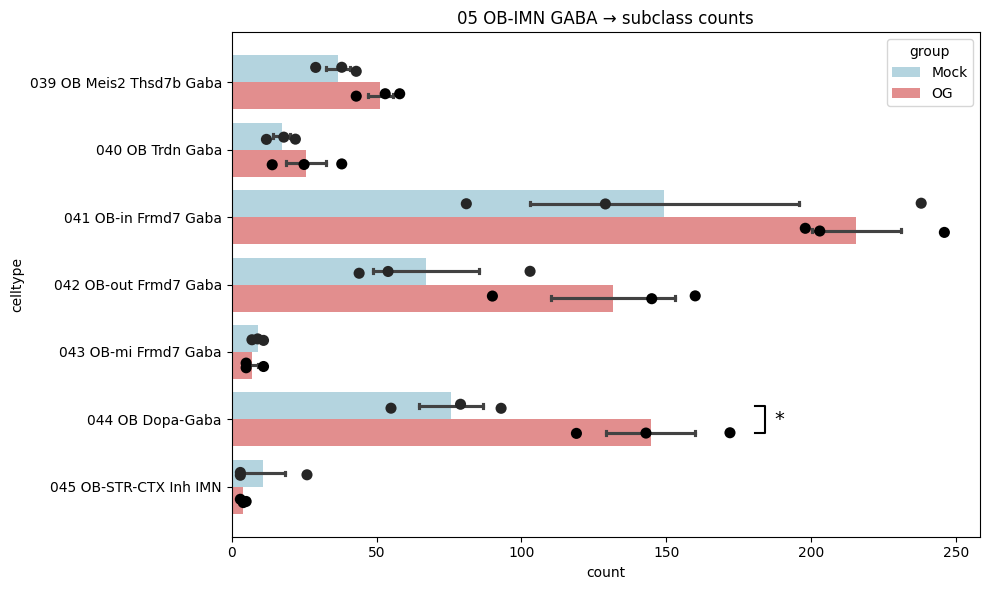

In [102]:
plot_grouped_subtype_counts(
    parent_level='class',
    parent_celltype='05 OB-IMN GABA',
    target_level='subclass',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)


/mnt/scratch/ipykernel_1311870/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/044_OB_Dopa-Gaba_supertype_horizontal.svg


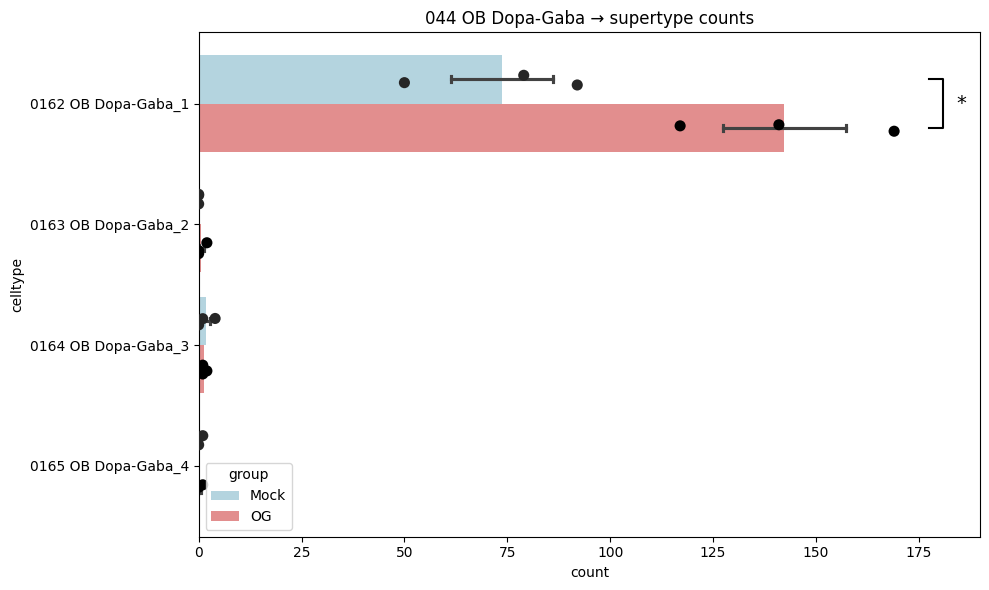

In [103]:
plot_grouped_subtype_counts(
    parent_level='subclass',
    parent_celltype='044 OB Dopa-Gaba',
    target_level='supertype',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)



/mnt/scratch/ipykernel_1311870/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/0162_OB_Dopa-Gaba_1_cluster_horizontal.svg


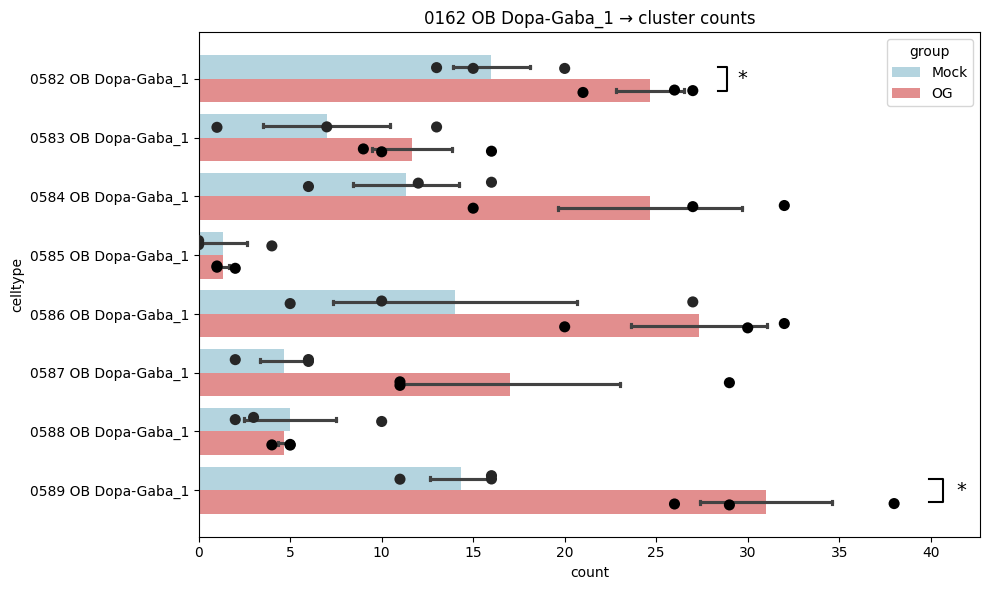

In [104]:
plot_grouped_subtype_counts(
    parent_level='supertype',
    parent_celltype='0162 OB Dopa-Gaba_1',
    target_level='cluster',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)


#### 14 HY Glut sub-plots...

/mnt/scratch/ipykernel_1311870/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/14_HY_Glut_subclass_horizontal.svg


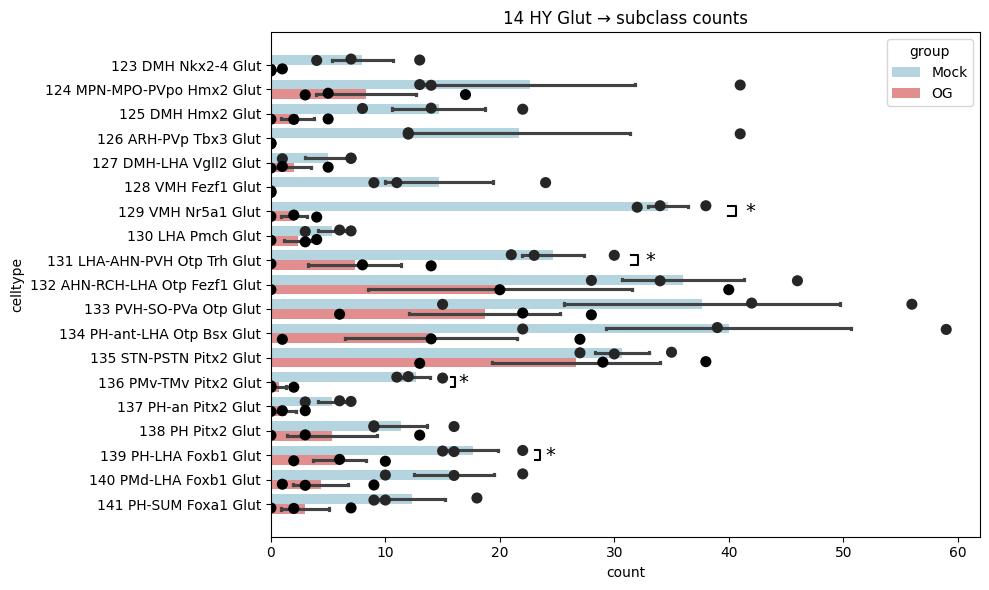

In [105]:
plot_grouped_subtype_counts(
    parent_level='class',
    parent_celltype='14 HY Glut',
    target_level='subclass',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)


/mnt/scratch/ipykernel_1311870/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/129_VMH_Nr5a1_Glut_supertype_horizontal.svg


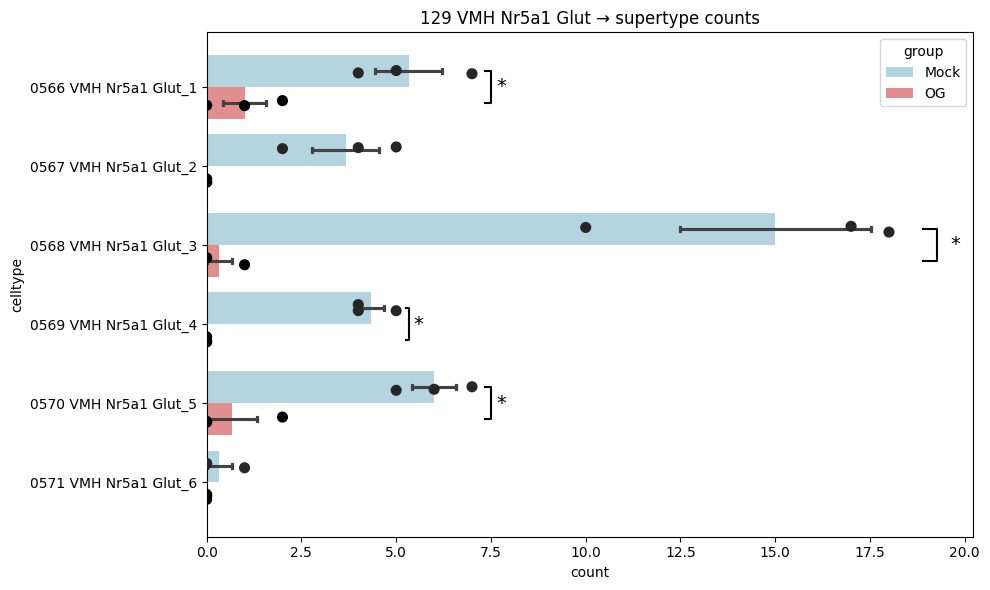

In [106]:
plot_grouped_subtype_counts(
    parent_level='subclass',
    parent_celltype='129 VMH Nr5a1 Glut',
    target_level='supertype',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)


/mnt/scratch/ipykernel_1311870/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/131_LHA-AHN-PVH_Otp_Trh_Glut_supertype_horizontal.svg


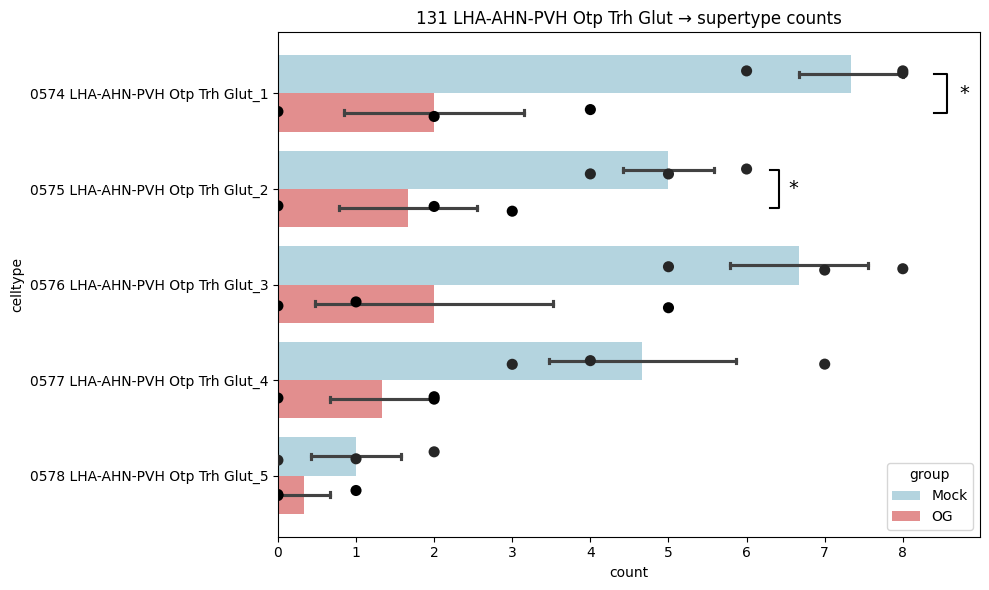

In [107]:
plot_grouped_subtype_counts(
    parent_level='subclass',
    parent_celltype='131 LHA-AHN-PVH Otp Trh Glut',
    target_level='supertype',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/136_PMv-TMv_Pitx2_Glut_supertype_horizontal.svg


/mnt/scratch/ipykernel_1311870/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


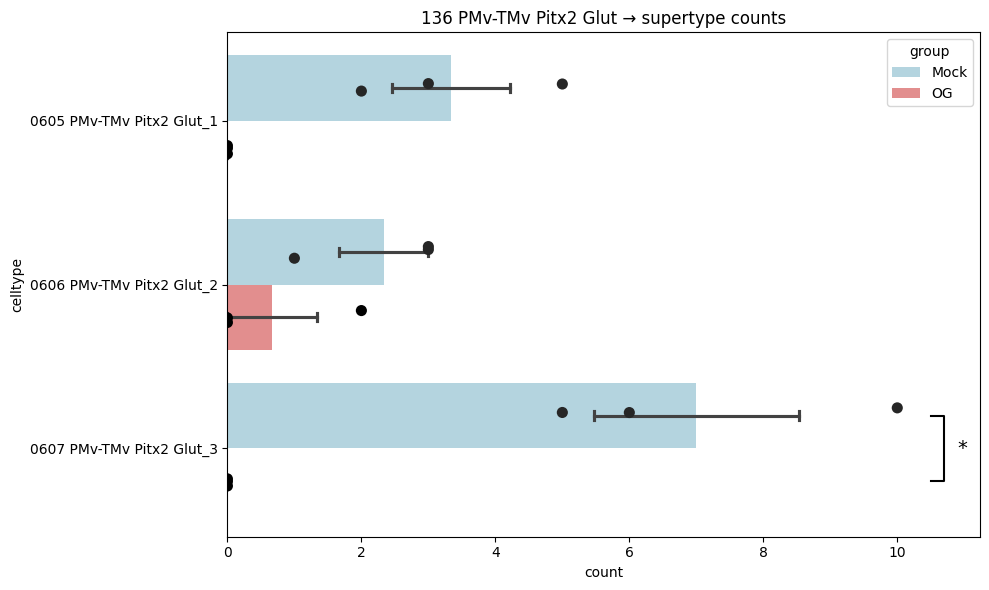

In [109]:
plot_grouped_subtype_counts(
    parent_level='subclass',
    parent_celltype='136 PMv-TMv Pitx2 Glut',
    target_level='supertype',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)


/home/jmk/pyenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/mnt/scratch/ipykernel_1311870/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/139_PH-LHA_Foxb1_Glut_supertype_horizontal.svg


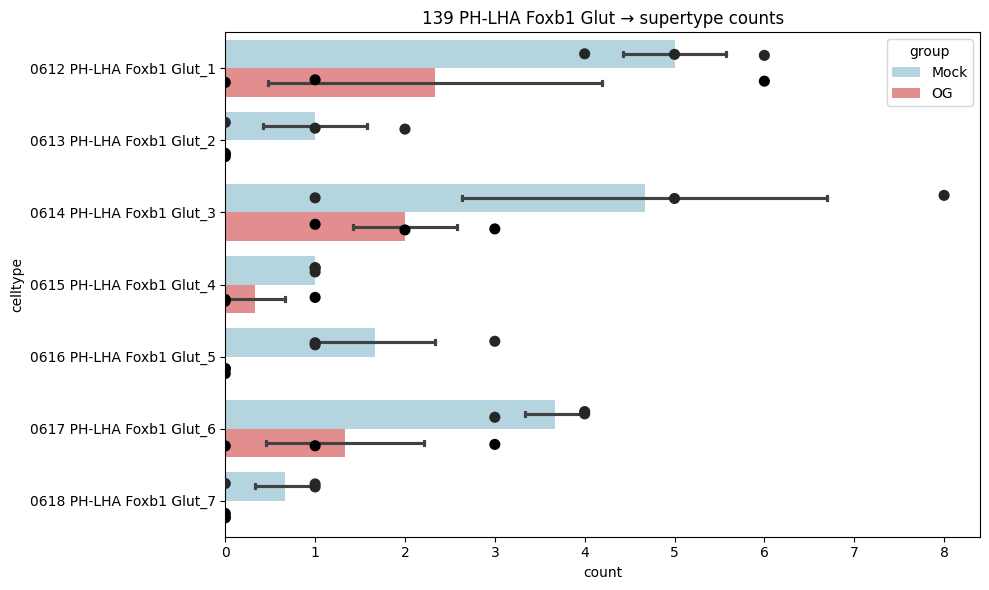

In [110]:
plot_grouped_subtype_counts(
    parent_level='subclass',
    parent_celltype='139 PH-LHA Foxb1 Glut',
    target_level='supertype',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)


/mnt/scratch/ipykernel_1529291/2185408734.py:96: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


Saved plot to: /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal/12_HY_GABA_subclass_horizontal.svg


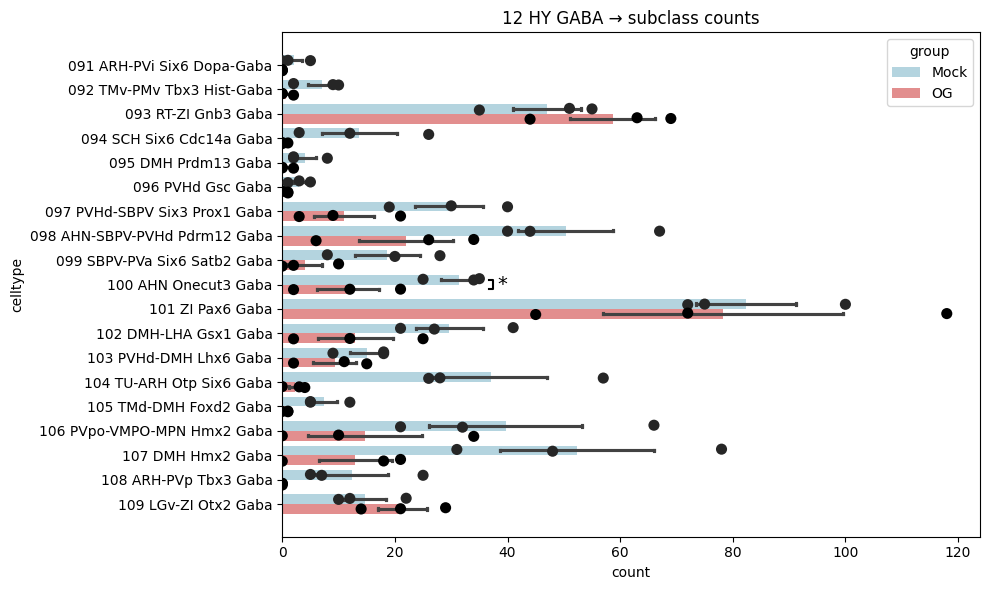

In [3]:
plot_grouped_subtype_counts(
    parent_level='class',
    parent_celltype='12 HY GABA',
    target_level='subclass',
    hierarchy_csv='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/celltype_hierarchy_mapping.csv',
    counts_base_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts',
    control_group='Mock',
    test_group='OG',
    correction_method='fdr_bh',   # 'fdr_bh', 'bonferroni', or None
    alpha=0.05,                    # significance threshold
    pval_type='p',                 # 'p' → raw t-test p-values, 'adj_pval' → corrected p-values
    orientation='h',               # 'v' → vertical bars, 'h' → horizontal bars
    show_pval=False,                # display numeric p-values above bars
    save_dir='/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Celltype_counts/Horizontal'                  # or provide a path to save the plot
)


### List of Cell types plotted

In [36]:
import re

# Read the notebook as text (assumes .ipynb file is available)
notebook_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Injest/05_Final_Brain_snRNAseq_Prunning_x_Cell_Analysis.ipynb"
with open(notebook_path, "r", encoding="utf-8") as f:
    nb_text = f.read()

# Regex to match cell type argument in plot_grouped_subtype_counts calls
pattern = re.compile(r"plot_grouped_subtype_counts\([^)]*parent_celltype\s*=\s*['\"]([^'\"]+)['\"]", re.MULTILINE)

cell_types = pattern.findall(nb_text)
cell_types = sorted(set(cell_types))

print("Cell types plotted in notebook:")
for ct in cell_types:
    print(ct)

Cell types plotted in notebook:
0162 OB Dopa-Gaba_1
044 OB Dopa-Gaba
05 OB-IMN GABA
12 HY GABA
129 VMH Nr5a1 Glut
131 LHA-AHN-PVH Otp Trh Glut
136 PMv-TMv Pitx2 Glut
139 PH-LHA Foxb1 Glut
14 HY Glut


# GSEA on DEG of sig dif cells

## Gene Lists Lynn wants (gene_lists)


In [5]:
import pandas as pd

# Path to the updated Excel file
excel_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Gene_Lists.xlsx"

# Load all sheets into a dictionary of DataFrames
df_sheets = pd.read_excel(excel_path, sheet_name=None)

# Initialize merged dictionary
gene_lists = {}

for sheet_name, df in df_sheets.items():
    # Clean sheet name
    cell_type = sheet_name.replace(" Genes", "").strip()

    # Ensure required columns exist
    required_cols = ["Direction", "Mouse_Gene"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' missing in sheet '{sheet_name}'")

    # Normalize direction column
    df["Direction"] = df["Direction"].astype(str).str.strip().str.lower()
    df["Mouse_Gene"] = df["Mouse_Gene"].astype(str).str.strip()

    # Filter up and down genes
    up_genes = df.loc[df["Direction"] == "u", "Mouse_Gene"].dropna().unique().tolist()
    down_genes = df.loc[df["Direction"] == "d", "Mouse_Gene"].dropna().unique().tolist()

    # Store in merged dict
    gene_lists[cell_type] = {
        "up": up_genes,
        "down": down_genes
    }

# Example: preview
for cell_type, dirs in gene_lists.items():
    print(f"{cell_type}: {len(dirs['up'])} up, {len(dirs['down'])} down")
    print("  Up:", dirs['up'][:5])
    print("  Down:", dirs['down'][:5])


Microglia: 76 up, 27 down
  Up: ['Il15', 'S100a4', 'Gpnmb', 'Plxnc1', 'Sectm1b']
  Down: ['Igsf10', 'Serpinf1', 'P2ry12', 'Cecr2', 'Glt1d1']
Astrocyte: 28 up, 11 down
  Up: ['Gfap', 'Sytl4', 'MT1E', 'ZFP36L1', 'MT2A']
  Down: ['Cck', 'Kcnip4', 'Rbfox1', 'RPL15', 'Raph1']
Neuron: 35 up, 33 down
  Up: ['Slc11a1', 'Rasgef1b', 'MTRNR2L8', 'Slc26a3', 'multiple']
  Down: ['Cck', 'Kcnip4', 'Rbfox1', 'Cox4i1', 'ATP5IF1']


## Cell-type DEG Reference (ref_df)

Note: Create a ref df for associating a cell type to the DEG excel files

In [10]:
import pandas as pd
import os

# Directory containing your Excel files
dge_dir = '/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/DGE'

# Map filenames to their annotation level
files_levels = {
    'DGE_level_class.xlsx': 'class',
    'DGE_level_subclass.xlsx': 'subclass',
    'DGE_level_supertype.xlsx': 'supertype',
    'DGE_level_cluster.xlsx': 'cluster'
}

records = []

for fname, level in files_levels.items():
    filepath = os.path.join(dge_dir, fname)
    # Get all sheet names
    xls = pd.ExcelFile(filepath)
    sheets = xls.sheet_names
    for sheet in sheets:
        records.append({
            'cell_type': sheet,
            'level': level,
            'excel_file': fname
        })

# Create DataFrame
ref_df = pd.DataFrame(records)

# Optional: save to CSV
ref_df.to_csv(os.path.join(dge_dir, 'celltype_to_level_reference.csv'), index=False)

print(ref_df.head())


         cell_type  level            excel_file
0     31 OPC-Oligo  class  DGE_level_class.xlsx
1  11 CNU-HYa GABA  class  DGE_level_class.xlsx
2  07 CTX-MGE GABA  class  DGE_level_class.xlsx
3       20 MB GABA  class  DGE_level_class.xlsx
4       14 HY Glut  class  DGE_level_class.xlsx


## Cell DGE lookup and GSEA plot

### Function for GSEA plots

In [ ]:
import os
import numpy as np
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

def run_celltype_gsea(
    cell_type,
    gene_set_name,
    save_path,
    DEG_path,
    ref_df,
    gene_list_dict,
    stat_col="logFC"  # column to rank genes by
):
    """
    Run GSEA for a specific cell type using DEGs from an Excel file, removing duplicates
    and adding a small jitter to prevent duplicated ranking values.

    Parameters
    ----------
    cell_type : str
        The cell type to analyze (must match a sheet name in the DEG Excel file).
    gene_set_name : str
        Key in gene_list_dict for the gene set to test.
        Lynn's dict: {'Microglia': 179, 'Astrocyte': 54, 'Neuron': 102}
    save_path : str or None
        Directory to save the .svg plot. If None, only displays plot.
    DEG_path : str
        Directory containing DEG Excel files.
    ref_df : pd.DataFrame
        Maps cell_type -> excel_file.
    gene_list_dict : dict
        Maps gene set names -> list of genes.
    stat_col : str
        Column in DEG file to use for ranking (default: logFC).
    """

    # Step 1 — Find the correct Excel file
    match_row = ref_df.loc[ref_df['cell_type'] == cell_type]
    if match_row.empty:
        raise ValueError(f"Cell type '{cell_type}' not found in reference DataFrame.")

    excel_filename = match_row['excel_file'].values[0]
    excel_full_path = os.path.join(DEG_path, excel_filename)
    if not os.path.exists(excel_full_path):
        raise FileNotFoundError(f"Excel file not found: {excel_full_path}")

    # Step 2 — Load DEG sheet
    try:
        df_deg = pd.read_excel(excel_full_path, sheet_name=cell_type)
    except ValueError:
        raise ValueError(f"Sheet '{cell_type}' not found in {excel_filename}")

    # Step 3 — Check column exists
    if stat_col not in df_deg.columns:
        raise ValueError(f"Column '{stat_col}' not found in DEG file for {cell_type}.")

    # Step 4 — Drop duplicate genes, keep highest absolute stat (most biologically meaningful?)
    df_deg = (
        df_deg[['gene', stat_col]]
        .dropna()
        .sort_values(by=stat_col, key=lambda x: x.abs(), ascending=False)
        .drop_duplicates(subset="gene", keep="first")
    )

    # Step 4b — Add tiny jitter to break duplicate ranking values
    rnk_series = df_deg.set_index('gene')[stat_col]
    rnk_series += np.random.normal(0, 1e-6, size=len(rnk_series))

    # Step 5 — Prepare gene set
    if gene_set_name not in gene_list_dict:
        raise ValueError(f"Gene set '{gene_set_name}' not found in gene_list_dict.")
    gene_set = {gene_set_name: gene_list_dict[gene_set_name]}

    # Step 6 — Run GSEA preranked
    res = gp.prerank(
        rnk=rnk_series,
        gene_sets=gene_set,
        threads=4,           # updated from deprecated 'processes'
        permutation_num=1000,
        outdir=None,
        seed=6
    )

    # Step 7 — Plot and save
    fig = res.plot(gene_set_name, figsize=(6, 5))
    fig.suptitle(f"GSEA: {cell_type} vs {gene_set_name} ({stat_col})", fontsize=12)

    if save_path:
        os.makedirs(save_path, exist_ok=True)
    # Include both cell type and gene set in filename
        safe_cell_type = cell_type.replace(' ', '_')
        safe_gene_set = gene_set_name.replace(' ', '_')
        fig_path = os.path.join(save_path, f"{safe_cell_type}_{safe_gene_set}_GSEA.svg")
        fig.savefig(fig_path, format='svg', bbox_inches='tight')
    else:
        plt.show()


    return res


#### testing dual plot new function

In [ ]:
import os
import numpy as np
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

def run_celltype_gsea(
    cell_type,
    gene_set_name,
    save_path,
    DEG_path,
    ref_df,
    gene_lists,
    stat_col="logFC",  # column to rank genes by
    split=False         # whether to subset DGE for up/down separately
):
    """
    Run GSEA for a specific cell type using DEGs from an Excel file,
    optionally splitting the DEG list into up- and down-regulated genes.

    Saves plots to: {save_path}/{cell_type}_{gene_set_name}_up.svg
                    {save_path}/{cell_type}_{gene_set_name}_down.svg
    """

    # Step 1 — Find the correct Excel file
    match_row = ref_df.loc[ref_df['cell_type'] == cell_type]
    if match_row.empty:
        raise ValueError(f"Cell type '{cell_type}' not found in reference DataFrame.")

    excel_filename = match_row['excel_file'].values[0]
    excel_full_path = os.path.join(DEG_path, excel_filename)
    if not os.path.exists(excel_full_path):
        raise FileNotFoundError(f"Excel file not found: {excel_full_path}")

    # Step 2 — Load DEG sheet
    try:
        df_deg = pd.read_excel(excel_full_path, sheet_name=cell_type)
    except ValueError:
        raise ValueError(f"Sheet '{cell_type}' not found in {excel_filename}")

    # Step 3 — Check stat column exists
    if stat_col not in df_deg.columns:
        raise ValueError(f"Column '{stat_col}' not found in DEG file for {cell_type}.")

    # Step 4 — Drop duplicate genes, keep highest absolute stat
    df_deg = (
        df_deg[['gene', stat_col]]
        .dropna()
        .sort_values(by=stat_col, key=lambda x: x.abs(), ascending=False)
        .drop_duplicates(subset="gene", keep="first")
    )

    # Step 5 — Loop through Up and Down
    results = {}
    for direction in ["up", "down"]:
        if gene_set_name not in gene_lists or direction not in gene_lists[gene_set_name]:
            print(f"⚠️ Gene set '{gene_set_name}' {direction} not found in gene_lists")
            continue

        genes = gene_lists[gene_set_name][direction]
        if not genes:
            print(f"⚠️ No genes found for {gene_set_name} {direction}")
            continue

        # Step 5a — Subset DEG if split=True
        if split:
            df_sub = df_deg[df_deg[stat_col] > 0] if direction == "up" else df_deg[df_deg[stat_col] < 0]
        else:
            df_sub = df_deg

        if df_sub.empty:
            print(f"⚠️ No DEG entries for {direction} in {cell_type}")
            continue

        # Step 5b — Add tiny jitter to break duplicate ranks
        rnk_series = df_sub.set_index('gene')[stat_col]
        rnk_series += np.random.normal(0, 1e-6, size=len(rnk_series))

        # Step 6 — Run preranked GSEA
        gene_set = {f"{gene_set_name}_{direction.upper()}": genes}
        res = gp.prerank(
            rnk=rnk_series,
            gene_sets=gene_set,
            threads=4,
            permutation_num=1000,
            min_size=1,
            outdir=None,
            seed=6
        )
        results[direction] = res.res2d

        # Step 7 — Plot and save
        fig = res.plot(list(gene_set.keys())[0], figsize=(6, 5))
        fig.suptitle(f"GSEA: {cell_type} vs {gene_set_name} ({direction.upper()})", fontsize=12)

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            safe_cell_type = cell_type.replace(' ', '_')
            safe_gene_set = gene_set_name.replace(' ', '_')
            fig_path = os.path.join(save_path, f"{safe_cell_type}_{safe_gene_set}_GSEA_{direction}.svg")
            fig.savefig(fig_path, format='svg', bbox_inches='tight')
            plt.close(fig)
        else:
            plt.show()

    return results


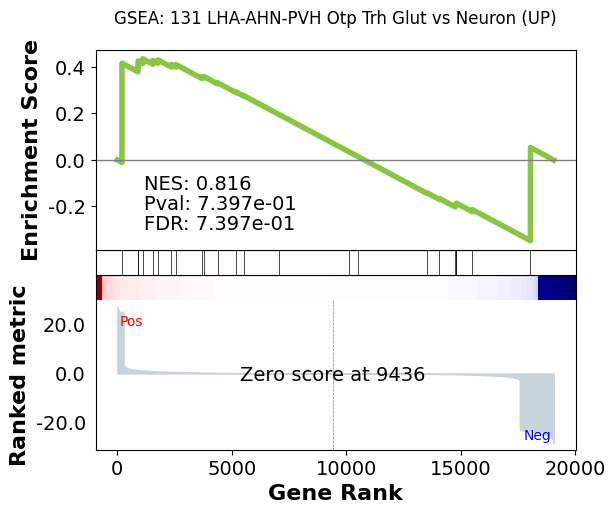

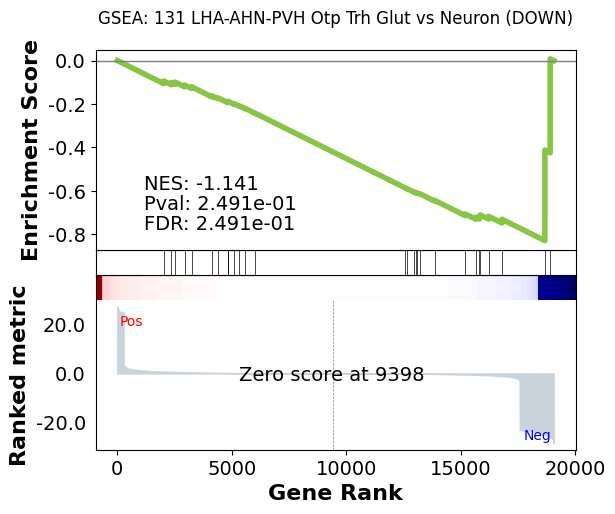

In [ ]:
gsea_results = run_celltype_gsea(
    cell_type="131 LHA-AHN-PVH Otp Trh Glut",
    gene_set_name="Neuron",
    save_path="/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/GSEA/All_DGE_UpDown_Genes",  # set folder path if you want to save
    DEG_path="/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/DGE",
    ref_df=ref_df,
    gene_lists=gene_lists,
    stat_col="logFC",
    split=False  # set to True to run up/down separately
    )


#### Looping through cell types for plotting...

In [39]:
'''
Note: The loop below was run multiple times to generate GSEA results for multiple cells and verious itterations of gene sets and splits.
'''

'\nNote: The loop below was run multiple times to generate GSEA results for multiple cells and verious itterations of gene sets and splits.\n'

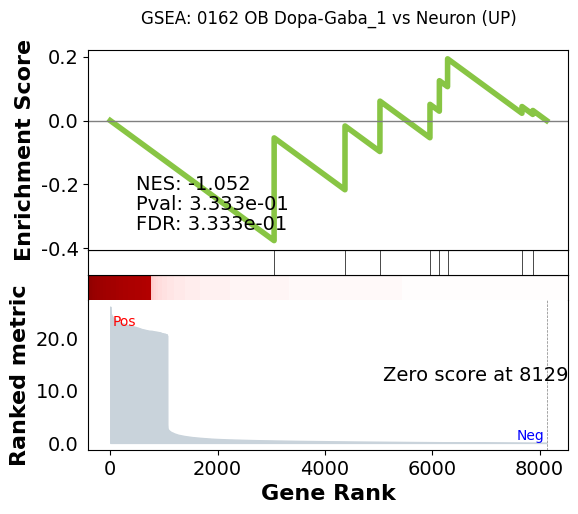

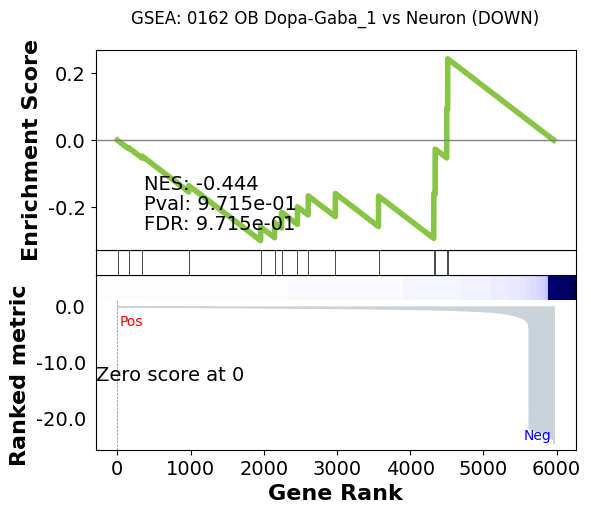

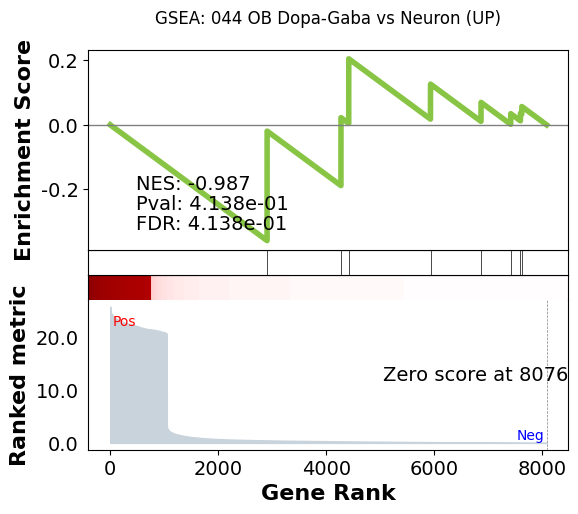

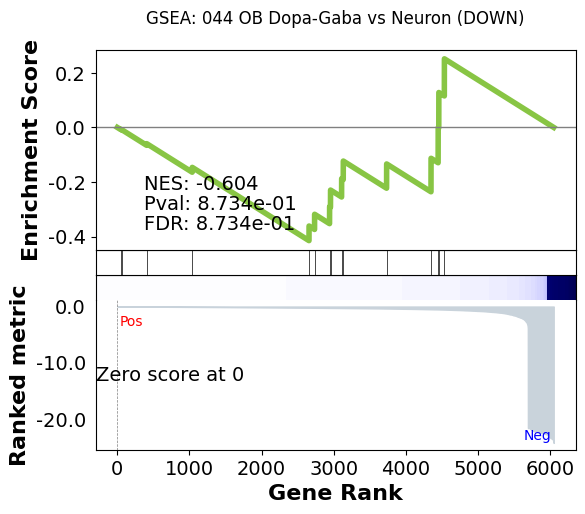

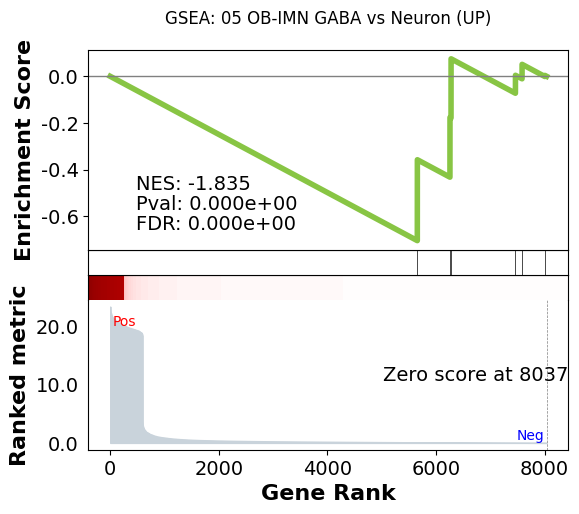

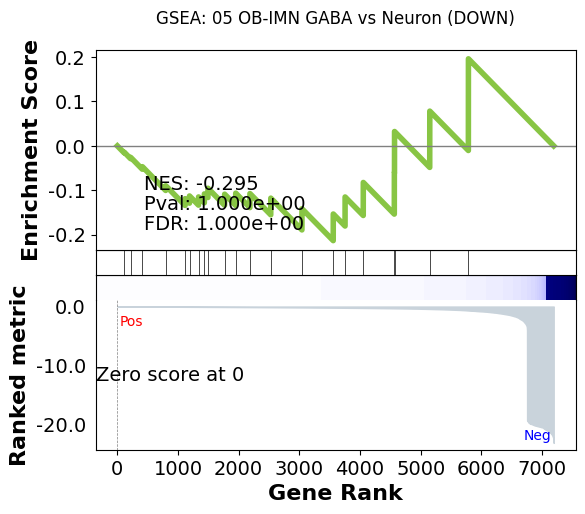

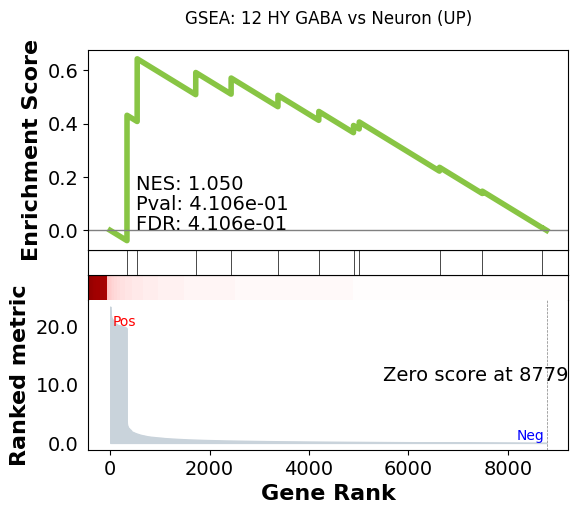

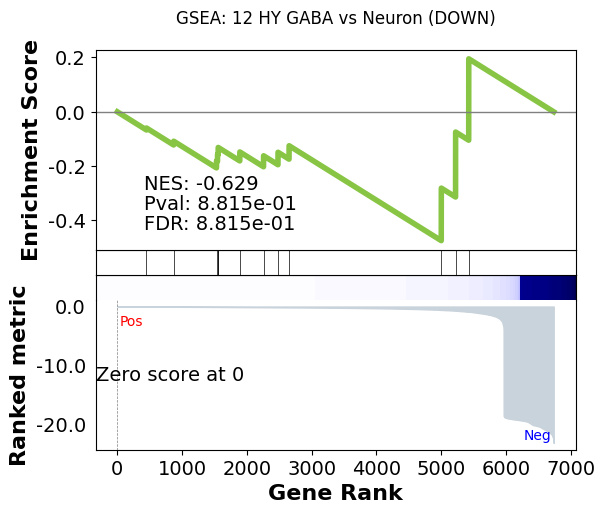

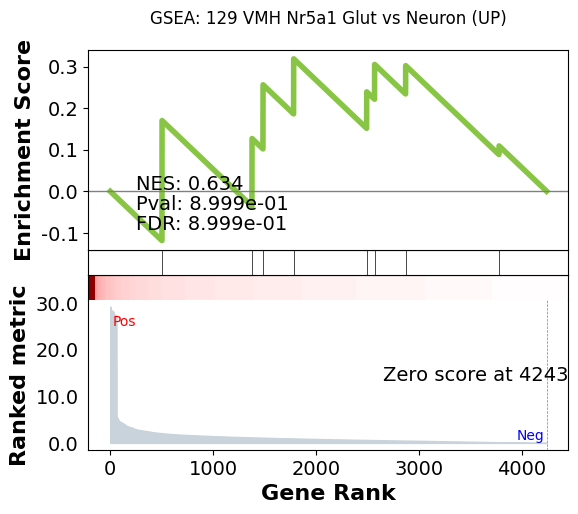

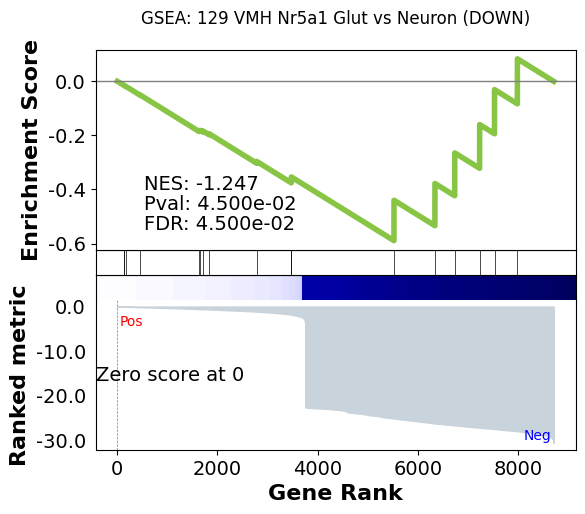

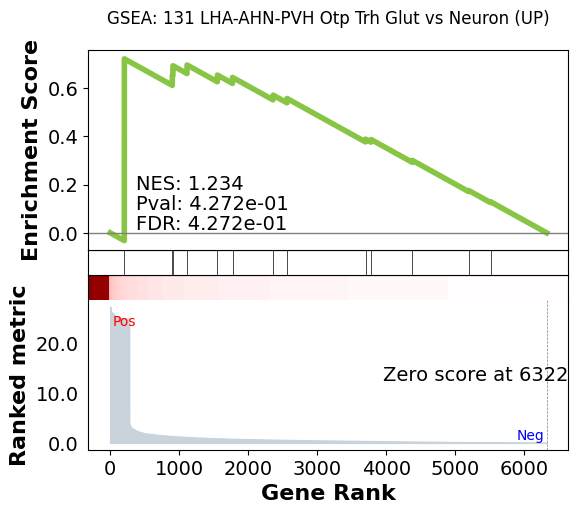

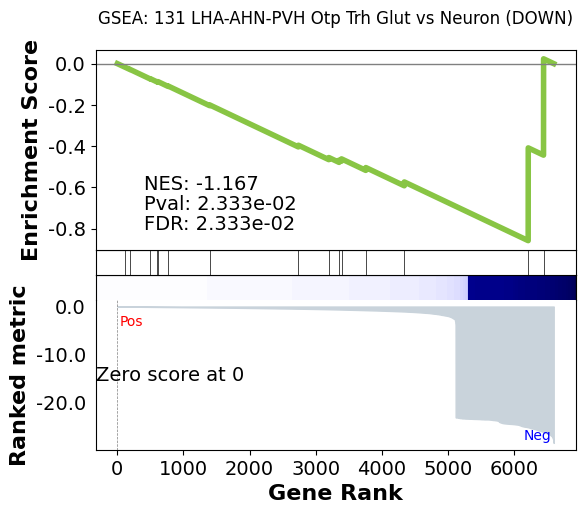

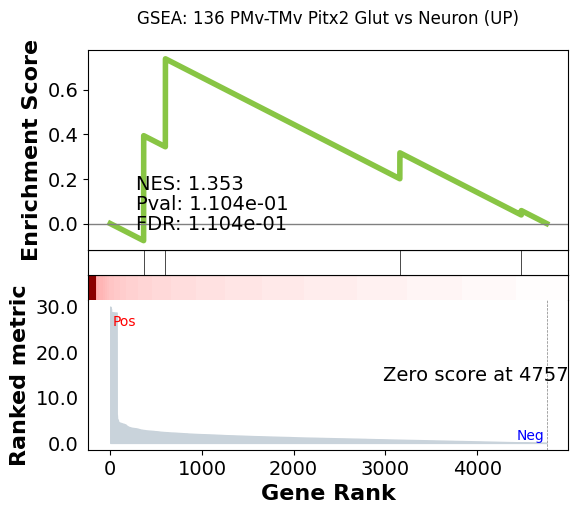

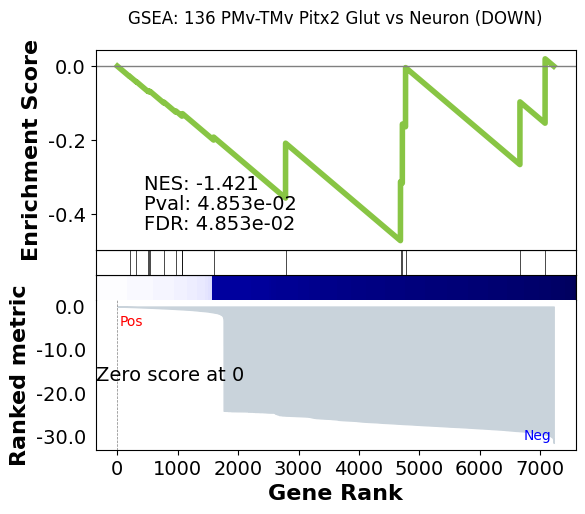

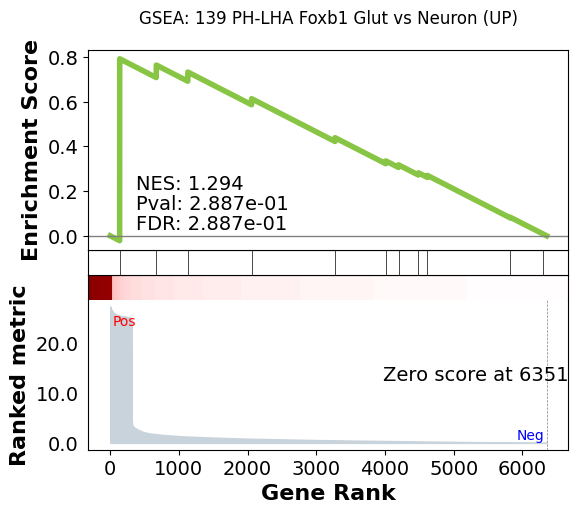

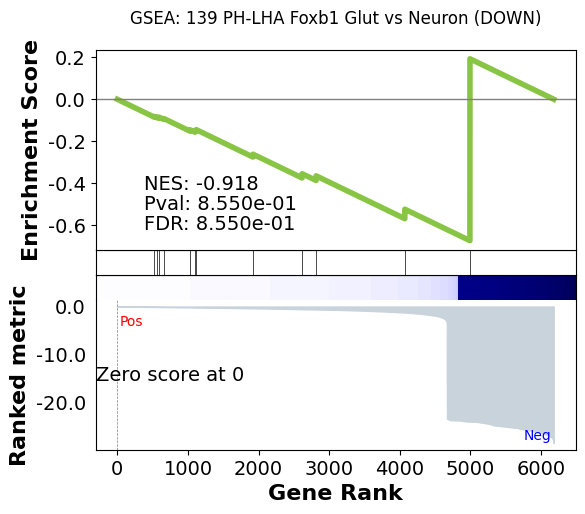

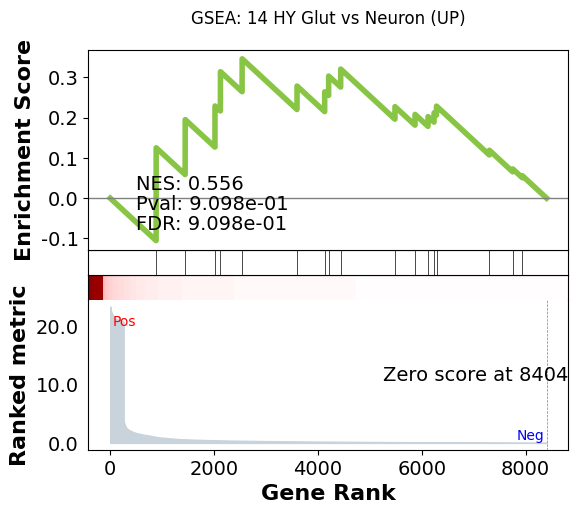

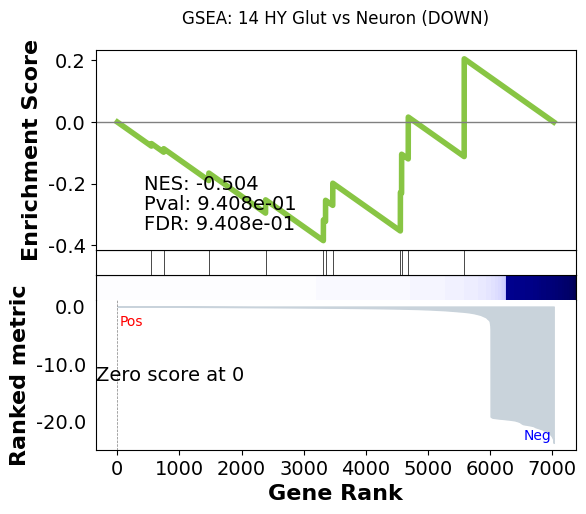

In [38]:
# List of cell types
cell_types = [
    "0162 OB Dopa-Gaba_1",
    "044 OB Dopa-Gaba",
    "05 OB-IMN GABA",
    "12 HY GABA",
    "129 VMH Nr5a1 Glut",
    "131 LHA-AHN-PVH Otp Trh Glut",
    "136 PMv-TMv Pitx2 Glut",
    "139 PH-LHA Foxb1 Glut",
    "14 HY Glut",
]

# Loop through cell types and run GSEA
for ct in cell_types:
    gsea_results = run_celltype_gsea(
        cell_type=ct,
        gene_set_name="Neuron",
        save_path="/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/GSEA/Split_DGE_UpDown_Genes",
        DEG_path="/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/DGE",
        ref_df=ref_df,
        gene_lists=gene_lists,
        stat_col="logFC",
        split=True
    )


# Microglia Analysis (Cluster 1.5: Homeostatic Microglia)

### Injest Homeostatic Microglia

In [24]:
import os
import scanpy as sc
import pandas as pd
import anndata as ad

# === Step 1: Setup ===
root_dir = "/media/drive_c/Project_Brain_snRNAseq/per_sample_outs"  # location of the per-sample 10x h5 files
barcodes_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/Cluster1.5_barcodes.csv"
output_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/Cluster1.5_cells_combined.h5ad"

# Load barcodes
barcodes = pd.read_csv(barcodes_path, header=None).squeeze("columns").astype(str)
barcodes_set = set(barcodes)

# === Step 2: Load and Process Each Sample ===
adatas = []

for sample_folder in os.listdir(root_dir):
    sample_path = os.path.join(root_dir, sample_folder, 'count', 'sample_filtered_feature_bc_matrix.h5')
    if not os.path.isfile(sample_path):
        continue

    print(f"Processing {sample_folder}...")

    # Load sample
    adata = sc.read_10x_h5(sample_path)
    adata.var_names_make_unique()

    # Keep raw counts
    adata.layers["counts"] = adata.X.copy()

    # Format barcodes (adjust if sample-barcode concatenation needed)
    adata.obs_names = [f"{bc}" for bc in adata.obs_names]

    # Subset to Cluster 1.5 barcodes only
    keep_cells = [bc for bc in adata.obs_names if bc in barcodes_set]
    if len(keep_cells) == 0:
        print(f"  -> No Cluster 1.5 cells found in {sample_folder}, skipping.")
        continue
    adata = adata[keep_cells].copy()

    # Add group label from folder name
    if 'Mock' in sample_folder:
        adata.obs['group'] = 'Mock'
    elif 'OG' in sample_folder:
        adata.obs['group'] = 'OG'
    else:
        adata.obs['group'] = 'Unknown'

    # Add sample label
    adata.obs['sample'] = sample_folder

    # Normalize + log transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.layers["log_norm"] = adata.X.copy()

    # Store raw counts in .raw for downstream DEG/GSEA
    adata.raw = adata.copy()

    adatas.append(adata)

# === Step 3: Concatenate All Samples ===
if len(adatas) == 0:
    raise ValueError("No Cluster 1.5 cells found in any sample!")
    
adata_Clust15 = ad.concat(adatas, label="sample", index_unique=None)

# Save combined Cluster 1.5 AnnData
adata_Clust15.write(output_path)

print(f"✅ Saved Cluster 1.5 AnnData: {adata_Clust15.shape} -> {output_path}")


Processing Mock-1...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing Mock-2...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing OG-3...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing OG-1...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing Mock-3...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing OG-2...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Saved Cluster 1.5 AnnData: (153, 19059) -> /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/Cluster1.5_cells_combined.h5ad


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [25]:
adata_Clust15

AnnData object with n_obs × n_vars = 153 × 19059
    obs: 'group', 'sample'
    layers: 'counts', 'log_norm'

### DGE analysis of OG vs Mock

In [26]:
import os
import pandas as pd
import scanpy as sc
from statsmodels.stats.multitest import multipletests

# === Parameters ===
group_key = 'group'
test_label = 'OG'
control_label = 'Mock'
logfc_thresh = 0.25
pval_thresh = 0.05
output_dir = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/"

# === Layer to use ===
layer_used = 'log_norm' if 'log_norm' in adata_Clust15.layers else None

# === Check groups ===
group_counts = adata_Clust15.obs[group_key].value_counts()
if test_label not in group_counts or control_label not in group_counts:
    raise ValueError(f"Both {test_label} and {control_label} must exist in {group_key} column.")
if group_counts[test_label] < 2 or group_counts[control_label] < 2:
    raise ValueError(f"Not enough cells in one of the groups to run DGE.")

# === Run DGE ===
sc.tl.rank_genes_groups(
    adata_Clust15,
    groupby=group_key,
    groups=[test_label],
    reference=control_label,
    method='wilcoxon',
    use_raw=False,
    layer=layer_used,
    n_genes=adata_Clust15.shape[1]
)

# === Extract results ===
dge_df = sc.get.rank_genes_groups_df(adata_Clust15, group=test_label)
dge_df.rename(columns={
    'names': 'gene',
    'pvals': 'p_val',
    'pvals_adj': 'scanpy_padj',
    'logfoldchanges': 'logFC'
}, inplace=True)
dge_df['p_val'] = dge_df['p_val'].fillna(1.0)

# === Recalculate FDR ===
p_adj = multipletests(dge_df['p_val'].values, method='fdr_bh')[1]
dge_df['p_adj'] = p_adj
dge_df['cell_type'] = 'Cluster1.5'

# === Save to Excel ===
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, "DGE_Cluster1.5.xlsx")
with pd.ExcelWriter(file_path) as writer:
    dge_df.to_excel(writer, sheet_name='Cluster1.5', index=False)

    # Add code info sheet
    code_string = f"""
# DGE Analysis Configuration
# Cluster: Cluster1.5
# Test vs Control: {test_label} vs {control_label}
# Minimum logFC threshold: {logfc_thresh}
# P-value threshold: {pval_thresh}
# Layer used: {layer_used if layer_used else 'X'}
# Method: Wilcoxon (Scanpy)
# FDR correction: Benjamini-Hochberg
"""
    pd.DataFrame({'Code': code_string.splitlines()}).to_excel(writer, sheet_name="Code_Used", index=False)

print(f"✅ DGE completed for Cluster 1.5, saved to {file_path}")


✅ DGE completed for Cluster 1.5, saved to /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/DGE_Cluster1.5.xlsx


### Microglia GSEA

In [31]:
import os
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt

# === Parameters ===
save_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/"
os.makedirs(save_path, exist_ok=True)

# Column to rank genes by
stat_col = 'logFC'  # from dge_df

# Step 1 — Prepare ranking series
rnk_series = dge_df[['gene', stat_col]].dropna().copy()

# Drop duplicates and keep highest absolute logFC
rnk_series = rnk_series.sort_values(by=stat_col, key=lambda x: x.abs(), ascending=False)
rnk_series = rnk_series.drop_duplicates(subset='gene', keep='first').set_index('gene')[stat_col]

# Add tiny jitter to break exact duplicates
rnk_series += np.random.normal(0, 1e-6, size=len(rnk_series))

# Step 2 — Run GSEA for each gene set in Lynn’s microglia gene list
for gene_set_name, gene_list in gene_lists_dict.items():
    gene_set = {gene_set_name: gene_list}

    res = gp.prerank(
        rnk=rnk_series,
        gene_sets=gene_set,
        threads=4,
        permutation_num=1000,
        outdir=None,  # We will save manually
        seed=6
    )

    # Step 3 — Plot GSEA
    fig = res.plot(gene_set_name, figsize=(6, 5))
    fig.suptitle(f"GSEA: Cluster1.5 vs {gene_set_name} ({stat_col})", fontsize=12)

    # Step 4 — Save as SVG
    safe_gene_set = gene_set_name.replace(' ', '_')
    fig_path = os.path.join(save_path, f"Cluster1.5_{safe_gene_set}_GSEA.svg")
    fig.savefig(fig_path, format='svg', bbox_inches='tight')
    plt.close(fig)

    print(f"✅ GSEA plot saved for {gene_set_name} at {fig_path}")


2025-08-19 12:33:21,435 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2025-08-19 12:33:21,436 [ERROR] The first entry of your gene_sets (gmt) look like this : { Astrocyte: [Mertk, Prelp, Gfap, Gpd1, Slc14a1, Mt2A, Nqo2, MEGF10, APP, MAPT, APOE, CLU, CR1, GFAP, SYTL4, MT1E, ZFP36L1, MT2A, GJA1, CNTNAP2, PLXNB1, CD81, ADGRG1, HSPA1A, GAPDH, DYNLL1, UBB, FTH1, CRYAB, PTMA, UBC, HSPB1, NDUFA4, STMN1, PCSK1N, COX7C, SH3BGRL3, HSP90AA1, HLA-DRA, HSPA8, APOD, MT2A, MT1E, CCK, KCNIP4, RBFOX1, RPL15, RAPH1, SLC1A2, NRXN1, NTM, CIRBP, CADM2, PLCB1]}
2025-08-19 12:33:21,436 [ERROR] The first 5 genes look like this : [ Kdr, Tm2d1, Oasl2, Zfp558, Mpv17l2 ]


✅ GSEA plot saved for Microglia at /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/Cluster1.5_Microglia_GSEA.svg


LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


### Reloading Microglia Genes into Up and Down Lists

In [43]:
import pandas as pd

# Path to your Excel file
excel_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Gene_List_for_AD.xlsx"

# Load all sheets into a dictionary of DataFrames
df_sheets = pd.read_excel(excel_path, sheet_name=None)

# Load the human↔mouse ortholog table
orthologs_path = "/media/drive_c/Project_Brain_snRNAseq/mouse_human_orthologs.csv"
orthologs_df = pd.read_csv(orthologs_path)

# Build mapping: human -> mouse
human_to_mouse = dict(zip(orthologs_df['Human_Gene'], orthologs_df['Mouse_Gene']))

# Create a set of all mouse genes in the ortholog file
mouse_genes_set = set(orthologs_df['Mouse_Gene'])

# Create a new dictionary specifically for microglia up/down
microglia_gene_sets_mouse = {}

for sheet_name, df in df_sheets.items():
    clean_name = sheet_name.replace(" Genes", "").strip()

    # Ensure column name matches exactly (case-insensitive)
    col = [c for c in df.columns if c.lower().strip() == "gene of interest".lower()][0]

    if clean_name.lower() == "microglia":
        # Split into up/down based on Direction column
        up_genes = df[df['Direction'] == 'u'][col].dropna().astype(str).str.strip().tolist()
        down_genes = df[df['Direction'] == 'd'][col].dropna().astype(str).str.strip().tolist()

        # Convert human genes to mouse genes, leave mouse genes unchanged
        up_genes_mouse = [
            human_to_mouse[g] if g in human_to_mouse else g
            for g in up_genes
        ]
        down_genes_mouse = [
            human_to_mouse[g] if g in human_to_mouse else g
            for g in down_genes
        ]

        # Store in dictionary
        microglia_gene_sets_mouse["Microglia_Up"] = up_genes_mouse
        microglia_gene_sets_mouse["Microglia_Down"] = down_genes_mouse

# Preview
for name, genes in microglia_gene_sets_mouse.items():
    print(f"{name}: {len(genes)} genes")
    print(genes[:5])


Microglia_Up: 78 genes
['Il15', 'S100a4', 'Gpnmb', 'Plxnc1', 'Sectm1b']
Microglia_Down: 29 genes
['Igsf10', 'Serpinf1', 'P2ry12', 'Cecr2', 'Glt1d1']


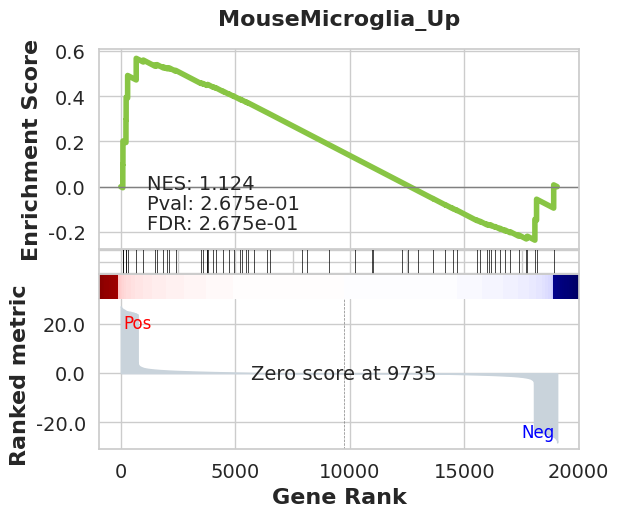

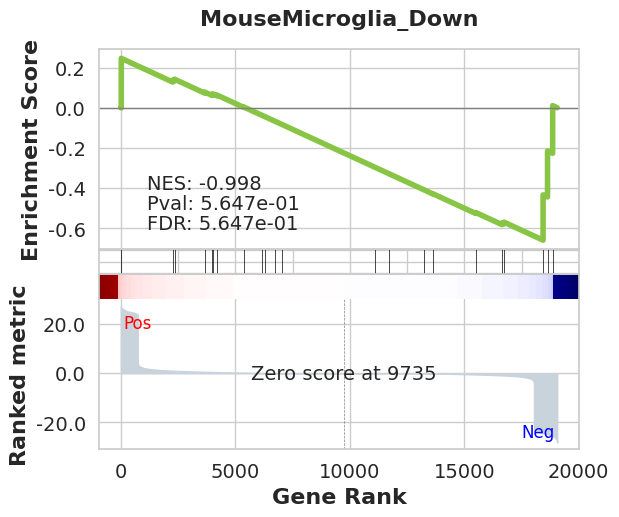

In [39]:
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt

# === Step 1: Load full Cluster 1.5 DGE results ===
dge_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/DGE_Cluster1.5.xlsx"
dge_df = pd.read_excel(dge_path, sheet_name=None)  # all sheets

# Combine all sheets into one DataFrame
dge_combined = pd.concat(dge_df.values(), ignore_index=True)

# Keep only relevant columns
dge_combined = dge_combined[['gene', 'logFC']].dropna().drop_duplicates(subset='gene')

# === Step 2: Load microglia gene list and convert human->mouse ===
excel_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Gene_List_for_AD.xlsx"
df_sheets = pd.read_excel(excel_path, sheet_name=None)

# Load orthologs
orthologs_path = "/media/drive_c/Project_Brain_snRNAseq/mouse_human_orthologs.csv"
orthologs_df = pd.read_csv(orthologs_path)
human_to_mouse = dict(zip(orthologs_df['Human_Gene'], orthologs_df['Mouse_Gene']))
mouse_genes_set = set(orthologs_df['Mouse_Gene'])

# Prepare mouse-converted microglia gene sets
microglia_gene_sets_mouse = {}
for sheet_name, df in df_sheets.items():
    clean_name = sheet_name.replace(" Genes", "").strip()
    if clean_name.lower() != "microglia":
        continue

    col_gene = [c for c in df.columns if c.lower().strip() == "gene of interest"][0]
    col_dir  = [c for c in df.columns if c.lower().strip() == "direction"][0]

    up_genes   = df[df[col_dir]=='u'][col_gene].dropna().astype(str).str.strip().tolist()
    down_genes = df[df[col_dir]=='d'][col_gene].dropna().astype(str).str.strip().tolist()

    # Convert human genes to mouse, keep mouse genes as-is
    up_genes_mouse = [human_to_mouse.get(g, g) for g in up_genes]
    down_genes_mouse = [human_to_mouse.get(g, g) for g in down_genes]

    microglia_gene_sets_mouse["MouseMicroglia_Up"] = up_genes_mouse
    microglia_gene_sets_mouse["MouseMicroglia_Down"] = down_genes_mouse

# === Step 3: Prepare ranked gene series for prerank ===
rnk_series = dge_combined.set_index('gene')['logFC'] + np.random.normal(0, 1e-6, len(dge_combined))

# === Step 4: Run GSEA and plot separately ===
for gene_set_name, gene_list in microglia_gene_sets_mouse.items():
    gene_set = {gene_set_name: gene_list}

    res = gp.prerank(
        rnk=rnk_series,
        gene_sets=gene_set,
        threads=4,
        permutation_num=1000,
        outdir=None,  # do not save
        seed=6
    )

    # Plot separately for each gene set
    res.plot(gene_set_name, figsize=(6,5))


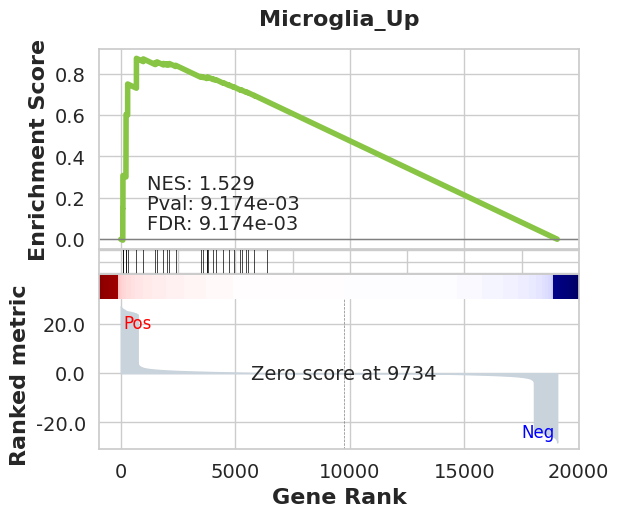

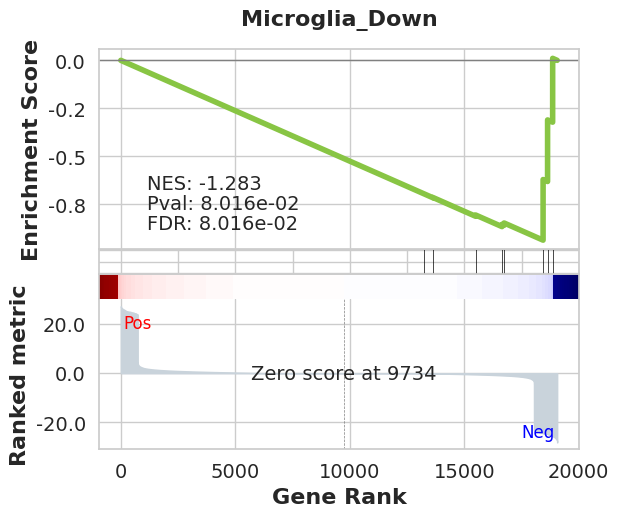

In [46]:
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt

# === Step 1: Load DGE results ===
dge_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/DGE_Cluster1.5.xlsx"
dge_df = pd.read_excel(dge_path, sheet_name=None)  # load all sheets
dge_combined = pd.concat(dge_df.values(), ignore_index=True)  # combine if multiple sheets

# Keep only relevant columns and remove duplicates
dge_combined = dge_combined[['gene', 'logFC']].dropna().drop_duplicates(subset='gene')

# Split DGE into up and down
dge_up = dge_combined[dge_combined['logFC'] > 0]
dge_down = dge_combined[dge_combined['logFC'] < 0]

# === Step 2: Filter microglia gene lists by DGE direction ===
up_genes_filtered = [
    g for g in microglia_gene_sets_mouse.get("Microglia_Up", [])
    if g in dge_up['gene'].values
]
down_genes_filtered = [
    g for g in microglia_gene_sets_mouse.get("Microglia_Down", [])
    if g in dge_down['gene'].values
]

microglia_gene_sets_mouse_filtered = {
    "Microglia_Up": up_genes_filtered,
    "Microglia_Down": down_genes_filtered
}

# === Step 3: Prepare ranked series for prerank GSEA ===
# Add tiny noise to avoid ties
rnk_series = dge_combined.set_index('gene')['logFC'] + np.random.normal(0, 1e-6, len(dge_combined))

# === Step 4: Run GSEA separately for up and down ===
for gene_set_name, gene_list in microglia_gene_sets_mouse_filtered.items():
    if not gene_list:
        print(f"Skipping {gene_set_name} because gene list is empty.")
        continue

    gene_set = {gene_set_name: gene_list}

    # Use min_size=1 only for the down gene set
    min_size_val = 1 if gene_set_name == "Microglia_Down" else 15

    res = gp.prerank(
        rnk=rnk_series,
        gene_sets=gene_set,
        threads=36,
        permutation_num=1000,
        outdir=None,  # do not save
        seed=6,
        min_size=min_size_val
    )

    # Plot GSEA separately
    res.plot(gene_set_name, figsize=(6,5))


In [51]:
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import os

# === Step 1: Load DGE results ===
dge_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Microglia_analysis/DGE_Cluster1.5.xlsx"
dge_df = pd.read_excel(dge_path, sheet_name=None)
dge_combined = pd.concat(dge_df.values(), ignore_index=True)
dge_combined = dge_combined[['gene', 'logFC']].dropna().drop_duplicates(subset='gene')

# Split DGE into up and down
dge_up = dge_combined[dge_combined['logFC'] > 0]
dge_down = dge_combined[dge_combined['logFC'] < 0]

# === Step 2: Filter microglia gene lists by DGE direction ===
up_genes_filtered = [
    g for g in microglia_gene_sets_mouse.get("Microglia_Up", [])
    if g in dge_up['gene'].values
]
down_genes_filtered = [
    g for g in microglia_gene_sets_mouse.get("Microglia_Down", [])
    if g in dge_down['gene'].values
]

microglia_gene_sets_mouse_filtered = {
    "Microglia_Up": up_genes_filtered,
    "Microglia_Down": down_genes_filtered
}

# === Step 3: Prepare ranked series for prerank GSEA ===
rnk_series = dge_combined.set_index('gene')['logFC'] + np.random.normal(0, 1e-6, len(dge_combined))

# === Step 4: Run GSEA separately for up and down and save plots ===
output_dir = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/GSEA"
os.makedirs(output_dir, exist_ok=True)

for gene_set_name, gene_list in microglia_gene_sets_mouse_filtered.items():
    if not gene_list:
        print(f"Skipping {gene_set_name} because gene list is empty.")
        continue

    gene_set = {gene_set_name: gene_list}
    min_size_val = 1 if gene_set_name == "Microglia_Down" else 15

    res = gp.prerank(
        rnk=rnk_series,
        gene_sets=gene_set,
        threads=32,
        permutation_num=1000,
        outdir=None,
        seed=6,
        min_size=min_size_val
    )

    # Plot and save using matplotlib
    ax = res.plot(gene_set_name, figsize=(10,8))
    save_path = os.path.join(output_dir, f"Microglia_{gene_set_name.split('_')[-1]}.svg")
    plt.savefig(save_path, format='svg')
    plt.close()  # Close the figure to avoid duplicate plots in notebook
    print(f"Saved GSEA plot for {gene_set_name} to {save_path}")


Saved GSEA plot for Microglia_Up to /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/GSEA/Microglia_Up.svg
Saved GSEA plot for Microglia_Down to /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/GSEA/Microglia_Down.svg


# Astrocyte Analysis

#### Ingest Astrocytes...

In [2]:
import os
import scanpy as sc
import pandas as pd
import anndata as ad

# === Step 1: Setup ===
root_dir = "/media/drive_c/Project_Brain_snRNAseq/per_sample_outs"  # location of the per-sample 10x h5 files
barcodes_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Astrocyte_analysis/astrocyte_cell_barcodes.csv"
output_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Astrocyte_analysis/astrocyte_cells.h5ad"

# Load barcodes
barcodes = pd.read_csv(barcodes_path, header=None).squeeze("columns").astype(str)
barcodes_set = set(barcodes)

# === Step 2: Load and Process Each Sample ===
adatas = []

for sample_folder in os.listdir(root_dir):
    sample_path = os.path.join(root_dir, sample_folder, 'count', 'sample_filtered_feature_bc_matrix.h5')
    if not os.path.isfile(sample_path):
        continue

    print(f"Processing {sample_folder}...")

    # Load sample
    adata = sc.read_10x_h5(sample_path)
    adata.var_names_make_unique()

    # Keep raw counts
    adata.layers["counts"] = adata.X.copy()

    # Format barcodes (adjust if sample-barcode concatenation needed)
    adata.obs_names = [f"{bc}" for bc in adata.obs_names]

    # Subset to Astrocyte barcodes only
    keep_cells = [bc for bc in adata.obs_names if bc in barcodes_set]
    if len(keep_cells) == 0:
        print(f"  -> No Astrocytes found in {sample_folder}, skipping.")
        continue
    adata = adata[keep_cells].copy()

    # Add group label from folder name
    if 'Mock' in sample_folder:
        adata.obs['group'] = 'Mock'
    elif 'OG' in sample_folder:
        adata.obs['group'] = 'OG'
    else:
        adata.obs['group'] = 'Unknown'

    # Add sample label
    adata.obs['sample'] = sample_folder

    # Normalize + log transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.layers["log_norm"] = adata.X.copy()

    # Store raw counts in .raw for downstream DEG/GSEA
    adata.raw = adata.copy()

    adatas.append(adata)

# === Step 3: Concatenate All Samples ===
if len(adatas) == 0:
    raise ValueError("No Astrocytes found in any sample!")
    
adata_astrocytes = ad.concat(adatas, label="sample", index_unique=None)

# Save combined Astros AnnData
adata_astrocytes.write(output_path)

print(f"✅ Saved Astrocyte AnnData: {adata_astrocytes.shape} -> {output_path}")


Processing Mock-1...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing Mock-2...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing OG-3...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing OG-1...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing Mock-3...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing OG-2...


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Saved Astrocyte AnnData: (218, 19059) -> /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Astrocyte_analysis/astrocyte_cells.h5ad


/home/jmk/pyenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata_astrocytes

AnnData object with n_obs × n_vars = 218 × 19059
    obs: 'group', 'sample'
    layers: 'counts', 'log_norm'

#### DGE of Astrocytes

In [4]:
import os
import pandas as pd
import scanpy as sc
from statsmodels.stats.multitest import multipletests

# === Parameters ===
group_key = 'group'
test_label = 'OG'
control_label = 'Mock'
logfc_thresh = 0.25
pval_thresh = 0.05
output_dir = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Astrocyte_analysis/"

# === Layer to use ===
layer_used = 'log_norm' if 'log_norm' in adata_astrocytes.layers else None

# === Check groups ===
group_counts = adata_astrocytes.obs[group_key].value_counts()
if test_label not in group_counts or control_label not in group_counts:
    raise ValueError(f"Both {test_label} and {control_label} must exist in {group_key} column.")
if group_counts[test_label] < 2 or group_counts[control_label] < 2:
    raise ValueError(f"Not enough cells in one of the groups to run DGE.")

# === Run DGE ===
sc.tl.rank_genes_groups(
    adata_astrocytes,
    groupby=group_key,
    groups=[test_label],
    reference=control_label,
    method='wilcoxon',
    use_raw=False,
    layer=layer_used,
    n_genes=adata_astrocytes.shape[1]
)

# === Extract results ===
dge_df = sc.get.rank_genes_groups_df(adata_astrocytes, group=test_label)
dge_df.rename(columns={
    'names': 'gene',
    'pvals': 'p_val',
    'pvals_adj': 'scanpy_padj',
    'logfoldchanges': 'logFC'
}, inplace=True)
dge_df['p_val'] = dge_df['p_val'].fillna(1.0)

# === Recalculate FDR ===
p_adj = multipletests(dge_df['p_val'].values, method='fdr_bh')[1]
dge_df['p_adj'] = p_adj
dge_df['cell_type'] = 'Astrocytes'

# === Save to Excel ===
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, "DGE_Astrocytes.xlsx")
with pd.ExcelWriter(file_path) as writer:
    dge_df.to_excel(writer, sheet_name='Astrocytes', index=False)

    # Add code info sheet
    code_string = f"""
# DGE Analysis Configuration
# Cluster: Astrocytes
# Test vs Control: {test_label} vs {control_label}
# Minimum logFC threshold: {logfc_thresh}
# P-value threshold: {pval_thresh}
# Layer used: {layer_used if layer_used else 'X'}
# Method: Wilcoxon (Scanpy)
# FDR correction: Benjamini-Hochberg
"""
    pd.DataFrame({'Code': code_string.splitlines()}).to_excel(writer, sheet_name="Code_Used", index=False)

print(f"✅ DGE completed for Astrocytes, saved to {file_path}")


✅ DGE completed for Astrocytes, saved to /media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Astrocyte_analysis/DGE_Astrocytes.xlsx


#### Modified GSEA Function

In [7]:
import os
import numpy as np
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

# === Inputs ===
deg_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Astrocyte_analysis/DGE_Astrocytes.xlsx"
sheet_name = "Astrocytes"
gene_set_name = "Astrocyte"
save_path = "/media/drive_c/Project_Brain_snRNAseq/Analysis/Results/Astrocyte_analysis"
stat_col = "logFC"
split = False  # True = separate up and down genes

# Example gene_lists dictionary
gene_lists = {
    "Astrocyte": {
        "up": ["GeneA", "GeneB", "GeneC"],
        "down": ["GeneX", "GeneY", "GeneZ"]
    }
}

# === Step 1. Load DEGs ===
df_deg = pd.read_excel(deg_path, sheet_name=sheet_name)

if stat_col not in df_deg.columns:
    raise ValueError(f"Column '{stat_col}' not found in sheet '{sheet_name}'.")

df_deg = (
    df_deg[['gene', stat_col]]
    .dropna()
    .sort_values(by=stat_col, key=lambda x: x.abs(), ascending=False)
    .drop_duplicates(subset="gene", keep="first")
)

# === Step 2. Loop through up and down ===
results = {}
for direction in ["up", "down"]:
    if gene_set_name not in gene_lists or direction not in gene_lists[gene_set_name]:
        print(f"⚠️ Gene set '{gene_set_name}' {direction} not found in gene_lists")
        continue

    genes = gene_lists[gene_set_name][direction]
    if not genes:
        print(f"⚠️ No genes found for {gene_set_name} {direction}")
        continue

    # Filter DEGs
    if split:
        df_sub = df_deg[df_deg[stat_col] > 0] if direction == "up" else df_deg[df_deg[stat_col] < 0]
    else:
        df_sub = df_deg

    if df_sub.empty:
        print(f"⚠️ No DEG entries for {direction} in {sheet_name}")
        continue

    # Ranking series
    rnk_series = df_sub.set_index('gene')[stat_col]
    rnk_series += np.random.normal(0, 1e-6, size=len(rnk_series))  # tiny jitter

    # Run preranked GSEA
    gene_set = {f"{gene_set_name}_{direction.upper()}": genes}
    res = gp.prerank(
        rnk=rnk_series,
        gene_sets=gene_set,
        threads=4,
        permutation_num=1000,
        min_size=1,
        outdir=None,
        seed=6
    )
    results[direction] = res.res2d

    # Plot and save
    fig = res.plot(list(gene_set.keys())[0], figsize=(6, 5))
    fig.suptitle(f"GSEA: {sheet_name} ({direction.upper()})", fontsize=12)

    os.makedirs(save_path, exist_ok=True)
    fig_path = os.path.join(save_path, f"{sheet_name}_{gene_set_name}_GSEA_{direction}.svg")
    fig.savefig(fig_path, format='svg', bbox_inches='tight')
    plt.close(fig)

print("✅ Finished GSEA. Results in `results` dictionary.")


2025-08-26 16:09:40,241 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2025-08-26 16:09:40,241 [ERROR] The first entry of your gene_sets (gmt) look like this : { Astrocyte_UP: [GeneA, GeneB, GeneC]}
2025-08-26 16:09:40,242 [ERROR] The first 5 genes look like this : [ Wnk4, Slc23a4, Higd1b, Anpep, Clec3b ]


LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.
